# Deep Learning comments toxicity classification

This project aims to develop a classification system for online comments with multiple categories of toxicity using the Tensorflow library. Specifically, a deep learning model with recurrent layers (Recurrent Neural Network) will be created, returning, for each comment, a vector of 6 elements (one for each category) with binary values (0, 1), depending on the presence of toxicity in one or more of the corresponding categories.

The model will be based on a dataset containing 160,000 comments, which are labelled with zero, one or more of the following categories of toxicity: Toxic, Severely Toxic, Obscene, Threat, Insult, Identity Hate.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from collections import Counter
import math
import os
import requests
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers, models
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay)

In [2]:
# Setting some parameters for matplotlib figures
plt.rcParams["figure.dpi"] = 240
sns.set_theme()

In [ ]:
# Load the original dataset
df_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv"
df = pd.read_csv(df_url)

## 1) Exploratory data analysis

First, an exploration of the dataset is peformed, to better understand the structure and composition of features and target variables.

### Dataset overview

In [4]:
# Dataset size and first 5 rows
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset size: 159571 rows and 8 columns


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [5]:
# General information on the dataset
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


In [6]:
# Count of null values per column
print("Null values:")
print(df.isnull().sum())

Null values:
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


None of the variables has null values, so no handling is required to clean the dataset in this regard.

### Distribution of toxicity categories

Here, the distribution of the different toxicity categories in the dataset is analysed, calculating and visualizing the absolute and relative frequency of each category.

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Total and percentage of positives per category
cat_counts = df[label_cols].sum().sort_values(ascending=False).rename('count').to_frame()
cat_counts['percentage'] = cat_counts['count'].div(cat_counts['count'].sum()).mul(100)
cat_counts

,count,percentage
toxic,15294,43.575132
obscene,8449,24.072597
insult,7877,22.442874
severe_toxic,1595,4.544418
identity_hate,1405,4.003077
threat,478,1.361901


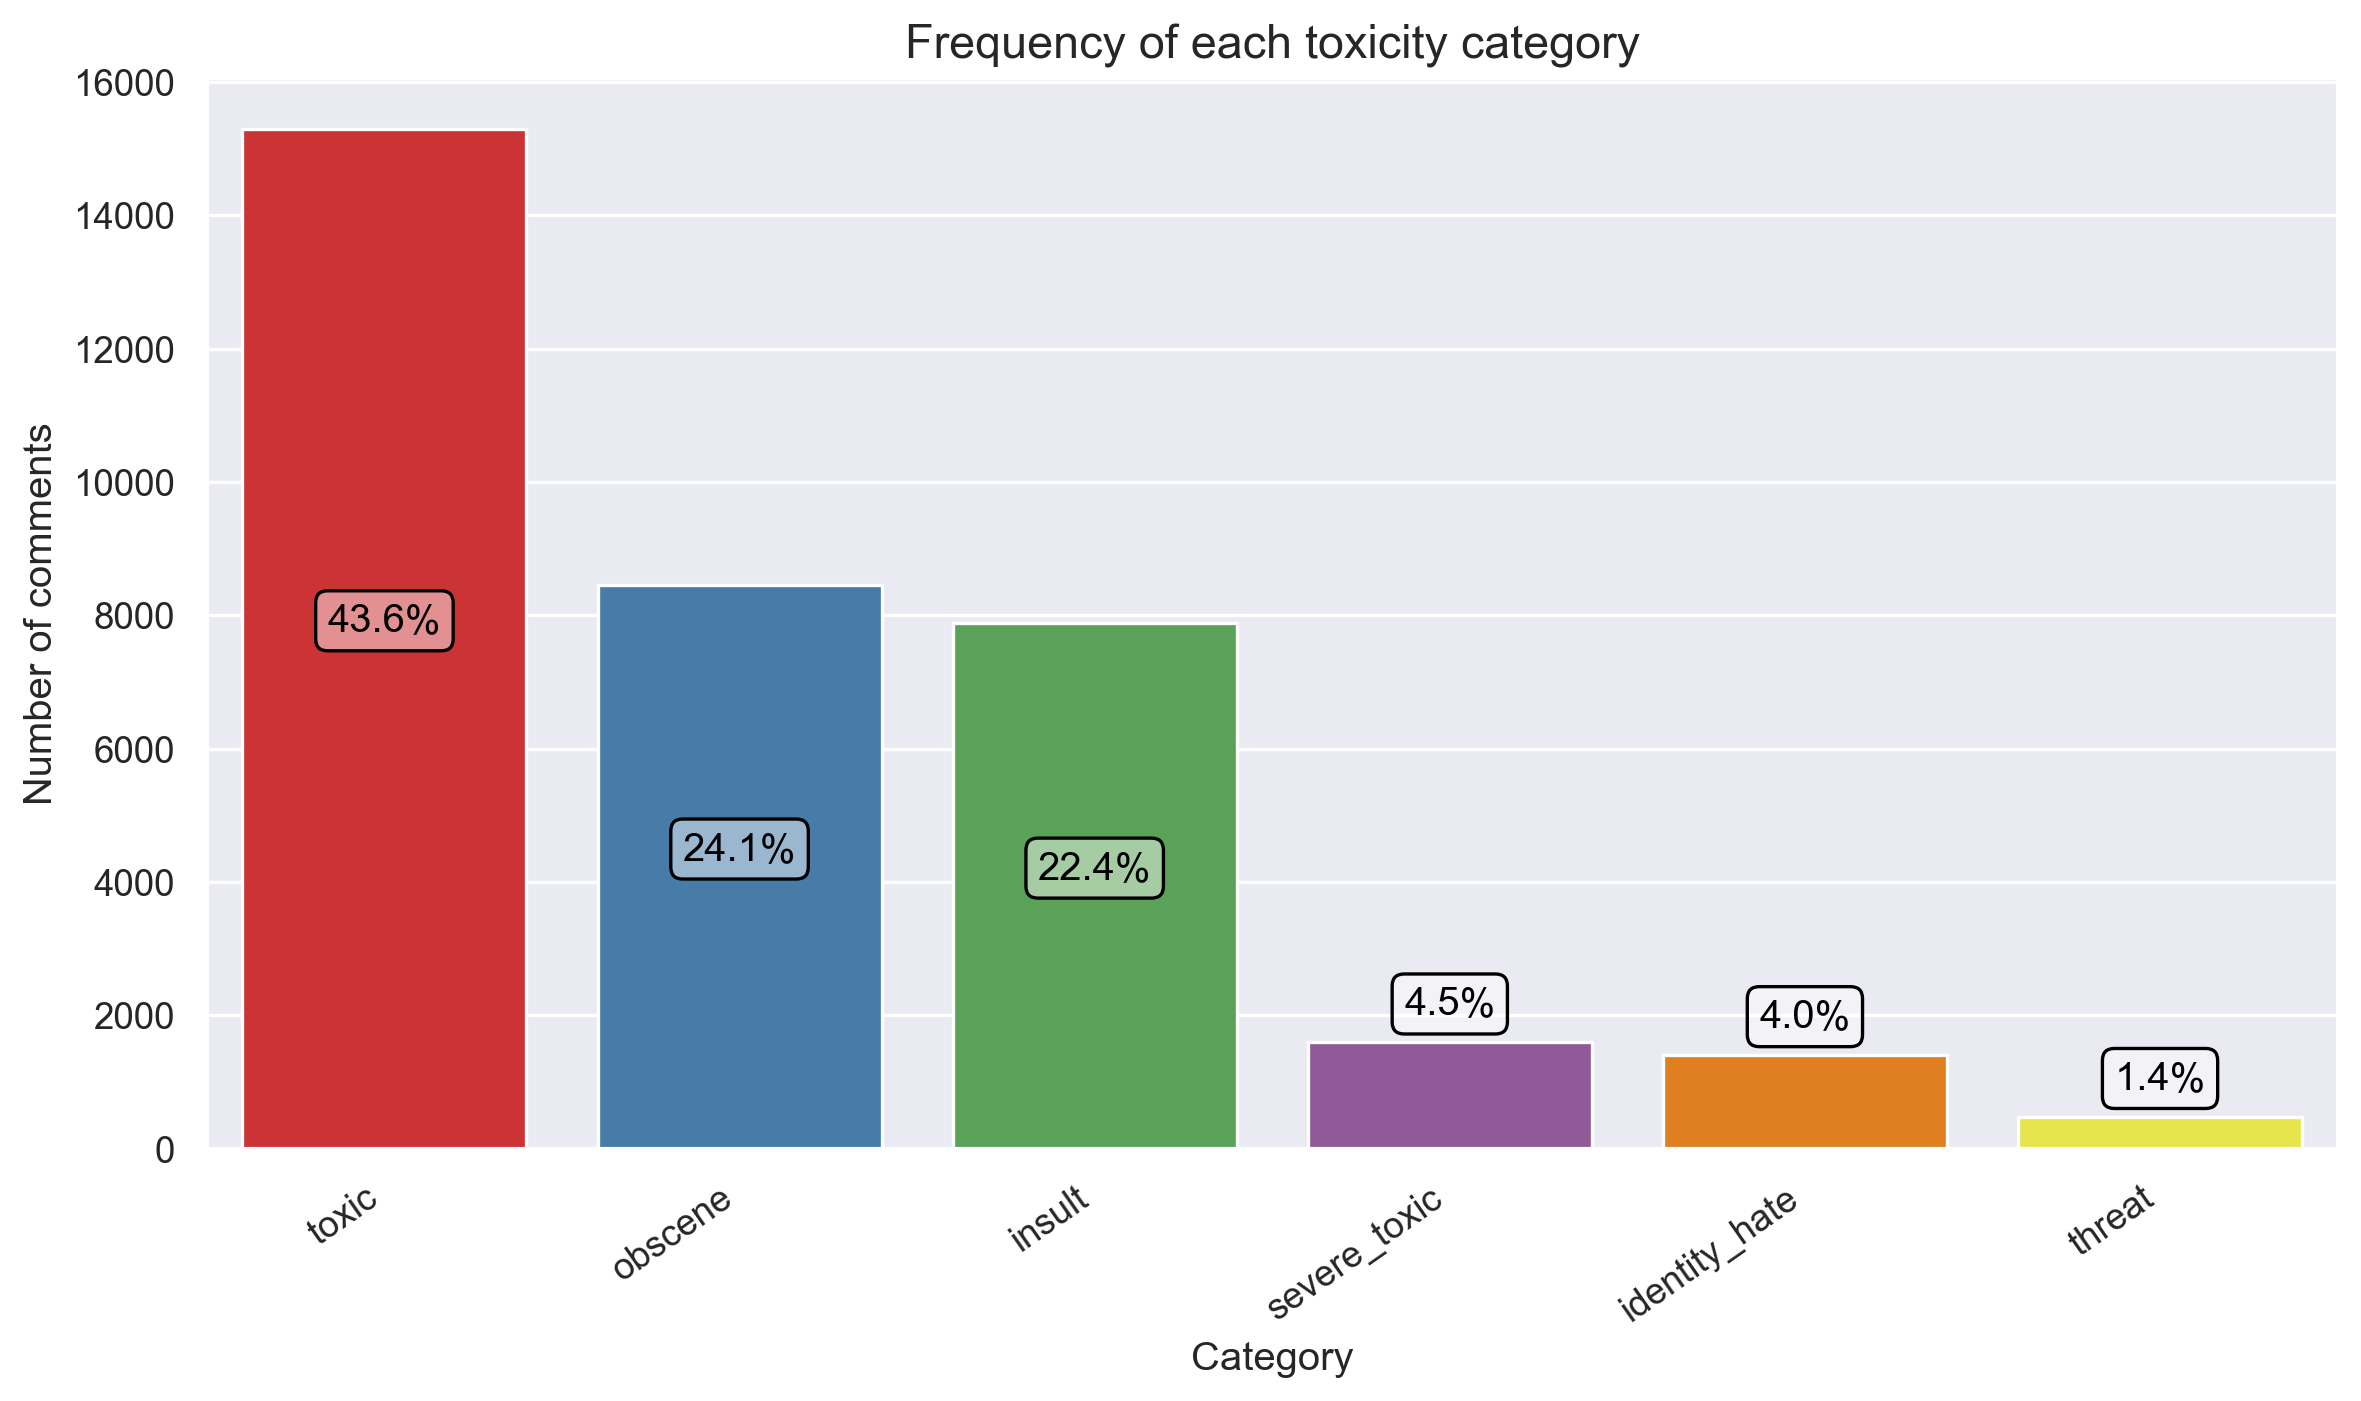

In [8]:
plt.figure(figsize=(10,6))

bars = sns.barplot(x=cat_counts.index, y=cat_counts['count'], hue=cat_counts.index, palette="Set1")

bar_max = cat_counts['count'].max()

for bar, pct in zip(bars.patches, cat_counts['percentage']):
    bars.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()/2 if bar.get_height()/2 > bar_max*.1 else bar.get_height() + 0.02 * bar_max,
        f'{pct:.1f}%',
        ha="center", va="bottom",
        fontsize=12, color="black",
        bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.xlabel("Category")
plt.ylabel("Number of comments")
plt.title("Frequency of each toxicity category", fontsize=14)
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

As can be observed, the distribution of samples among the different categories is highly imbalanced.

Now, a comparison between all comments with toxicity and the “clean” comments (with no toxicity label) is performed.

In [9]:
# Clean (no label) vs. with toxicty (≥1 label) comments
df['has_toxicity'] = (df["sum_injurious"] > 0)

In [10]:
clean_toxic_count = df['has_toxicity'].value_counts().rename({False: 'clean', True: '≥1 toxic label'})
clean_toxic_pct = df['has_toxicity'].value_counts(normalize=True).rename({False: 'clean', True: '≥1 toxic label'}) * 100

print("Distribution of clean vs toxic comments:")
print(f"  Clean: {clean_toxic_count.iloc[0]} comments ({clean_toxic_pct.iloc[0]:.2f}%)")
print(f"  With toxicity: {clean_toxic_count.iloc[1]} comments ({clean_toxic_pct.iloc[1]:.2f}%)")

Distribution of clean vs toxic comments:
  Clean: 143346 comments (89.83%)
  With toxicity: 16225 comments (10.17%)


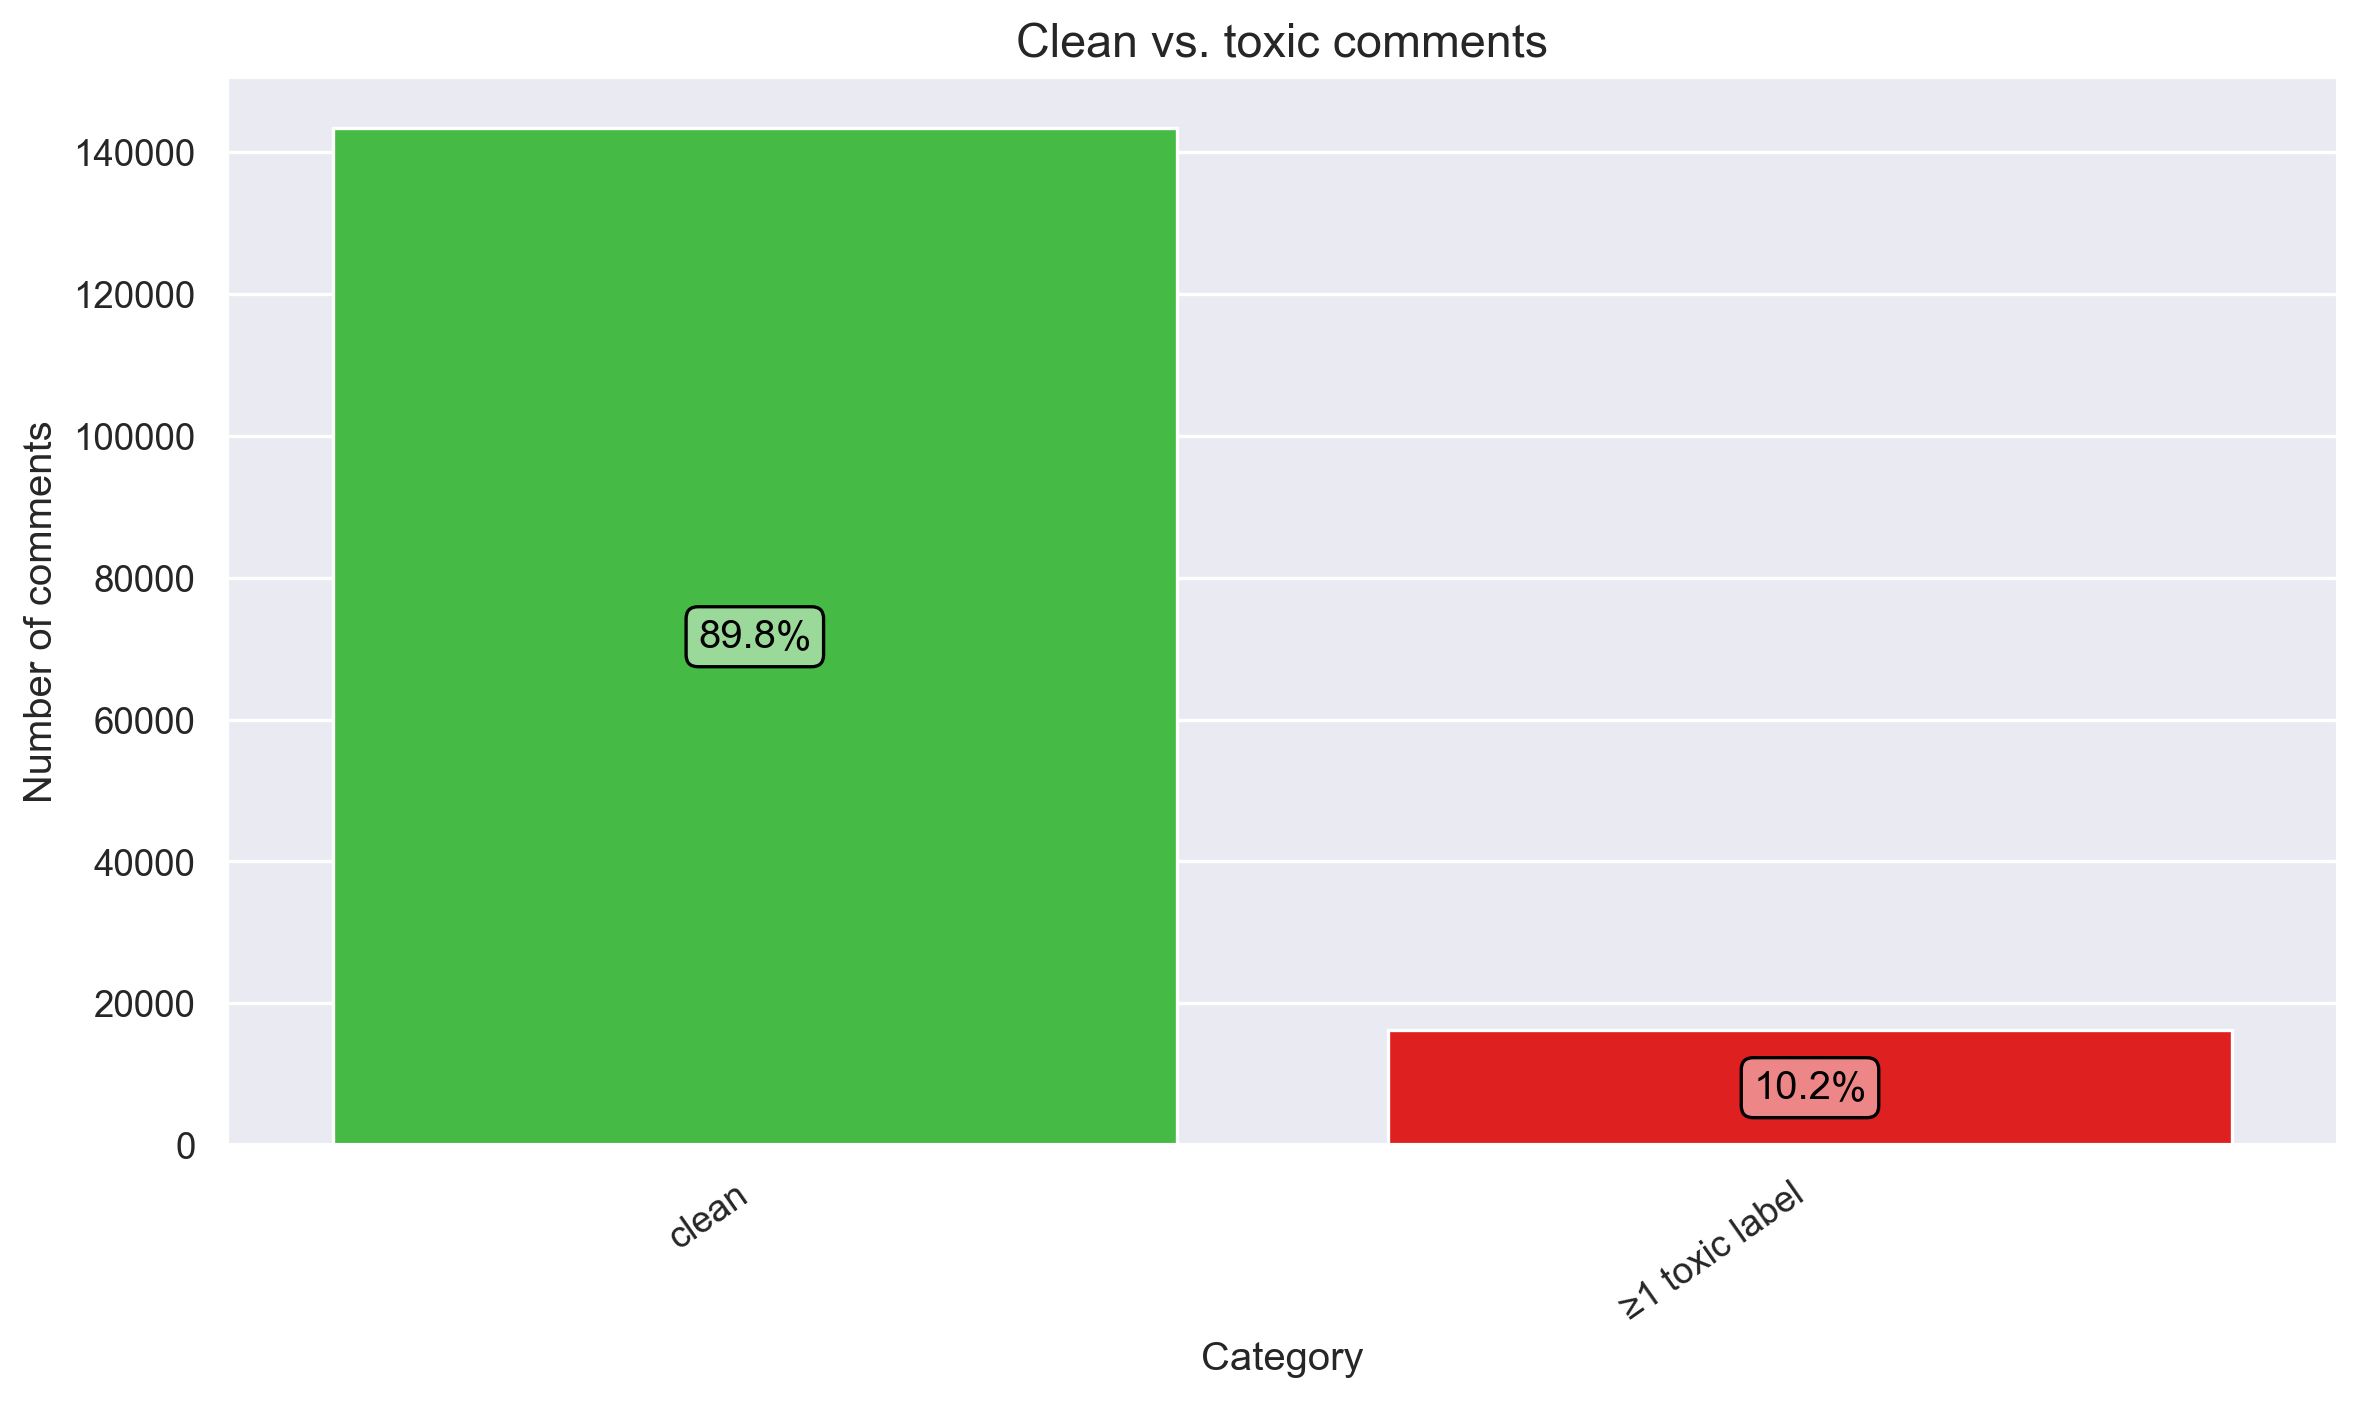

In [11]:
# Bar plot of toxicity presence
plt.figure(figsize=(10,6))
sns.barplot(x=clean_toxic_count.index, y=clean_toxic_count.values, hue=clean_toxic_count.index, palette=['limegreen', 'red'])
plt.xlabel("Category")
plt.ylabel("Number of comments")
plt.title("Clean vs. toxic comments", fontsize=14)
plt.xticks(rotation=35, ha='right')

for i, count in enumerate(clean_toxic_count):
    plt.annotate(f"{clean_toxic_pct.iloc[i]:.1f}%",
                 xy=(i, clean_toxic_count.iloc[i]/2),
                 ha='center', va='center',
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.tight_layout()
plt.show()

It can be observed that the distribution of the "clean" vs "toxic" samples is strongly inbalanced, since 89.8% of comments have no toxicity labels.

Next, a count of the number of toxicity labels per comment is made, to highlight the prevalence of multi-label samples in the dataset.

In [12]:
# Number of toxicity categories per comment
sum_counts = df['sum_injurious'].value_counts().sort_index()
sum_counts

sum_injurious
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

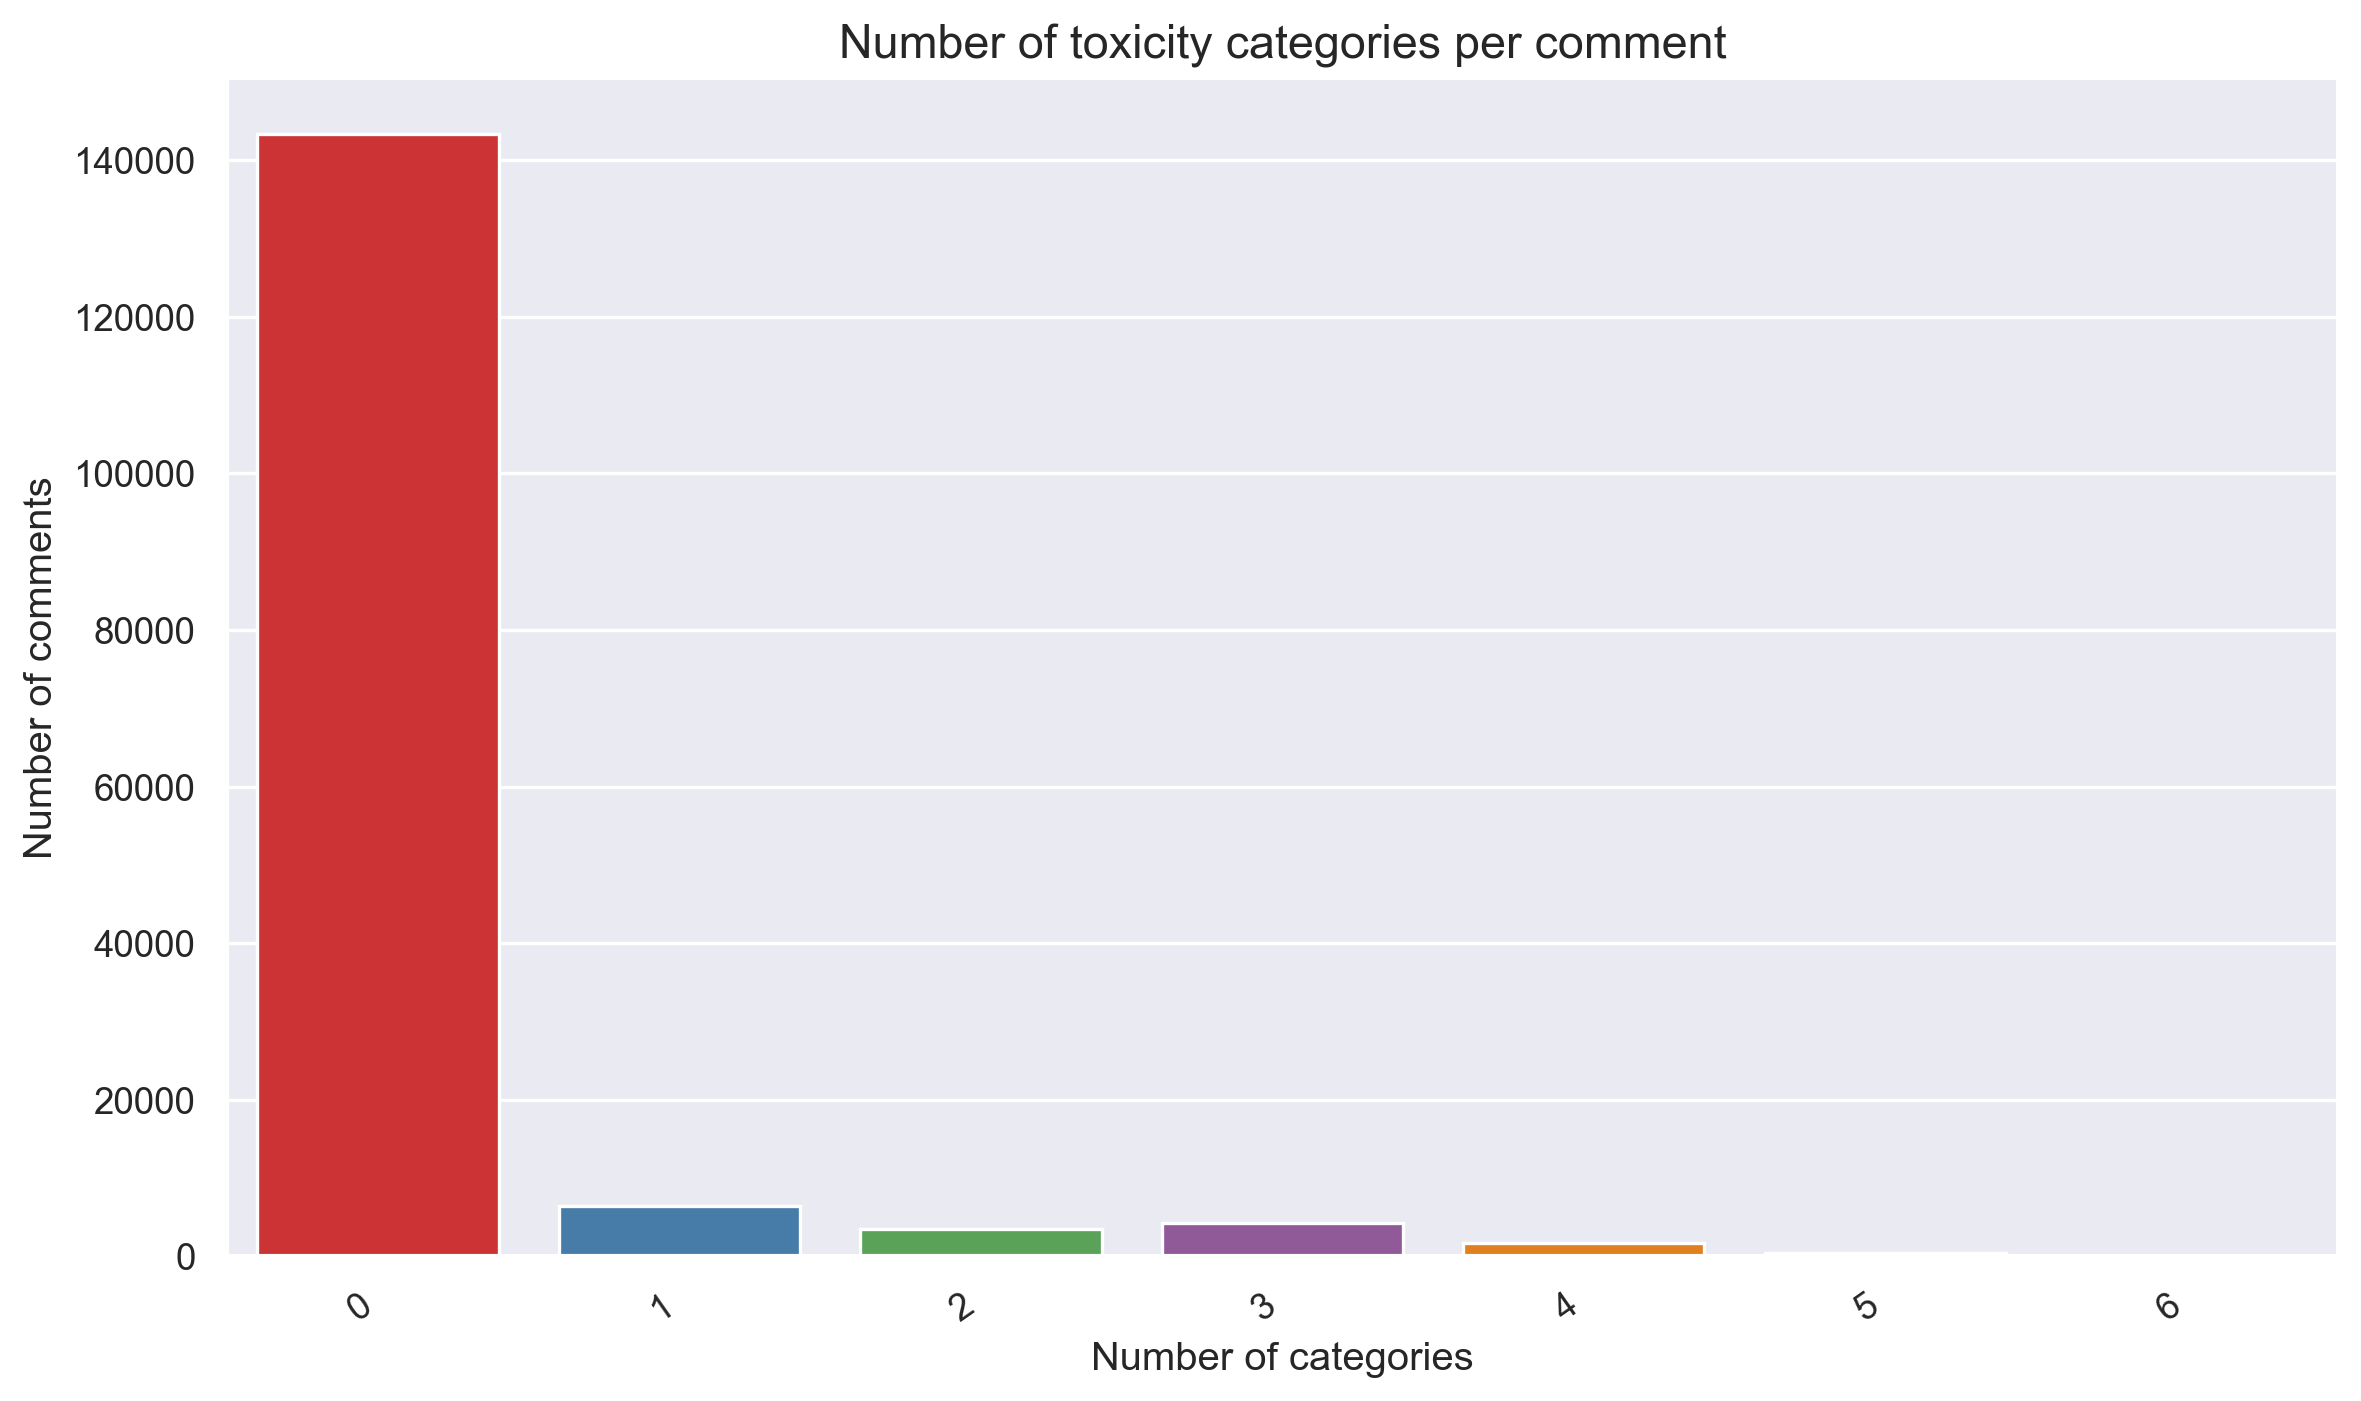

In [13]:
# Bar plot of categories per comment
plt.figure(figsize=(10,6))
sns.barplot(x=sum_counts.index, y=sum_counts.values, hue=sum_counts.index, palette="Set1", legend=False)
plt.xlabel("Number of categories")
plt.ylabel("Number of comments")
plt.title("Number of toxicity categories per comment", fontsize=14)
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

### Correlation among toxicity labels

Here, a pairwise correlation of toxicity categories in the dataset is calculated and visualized.

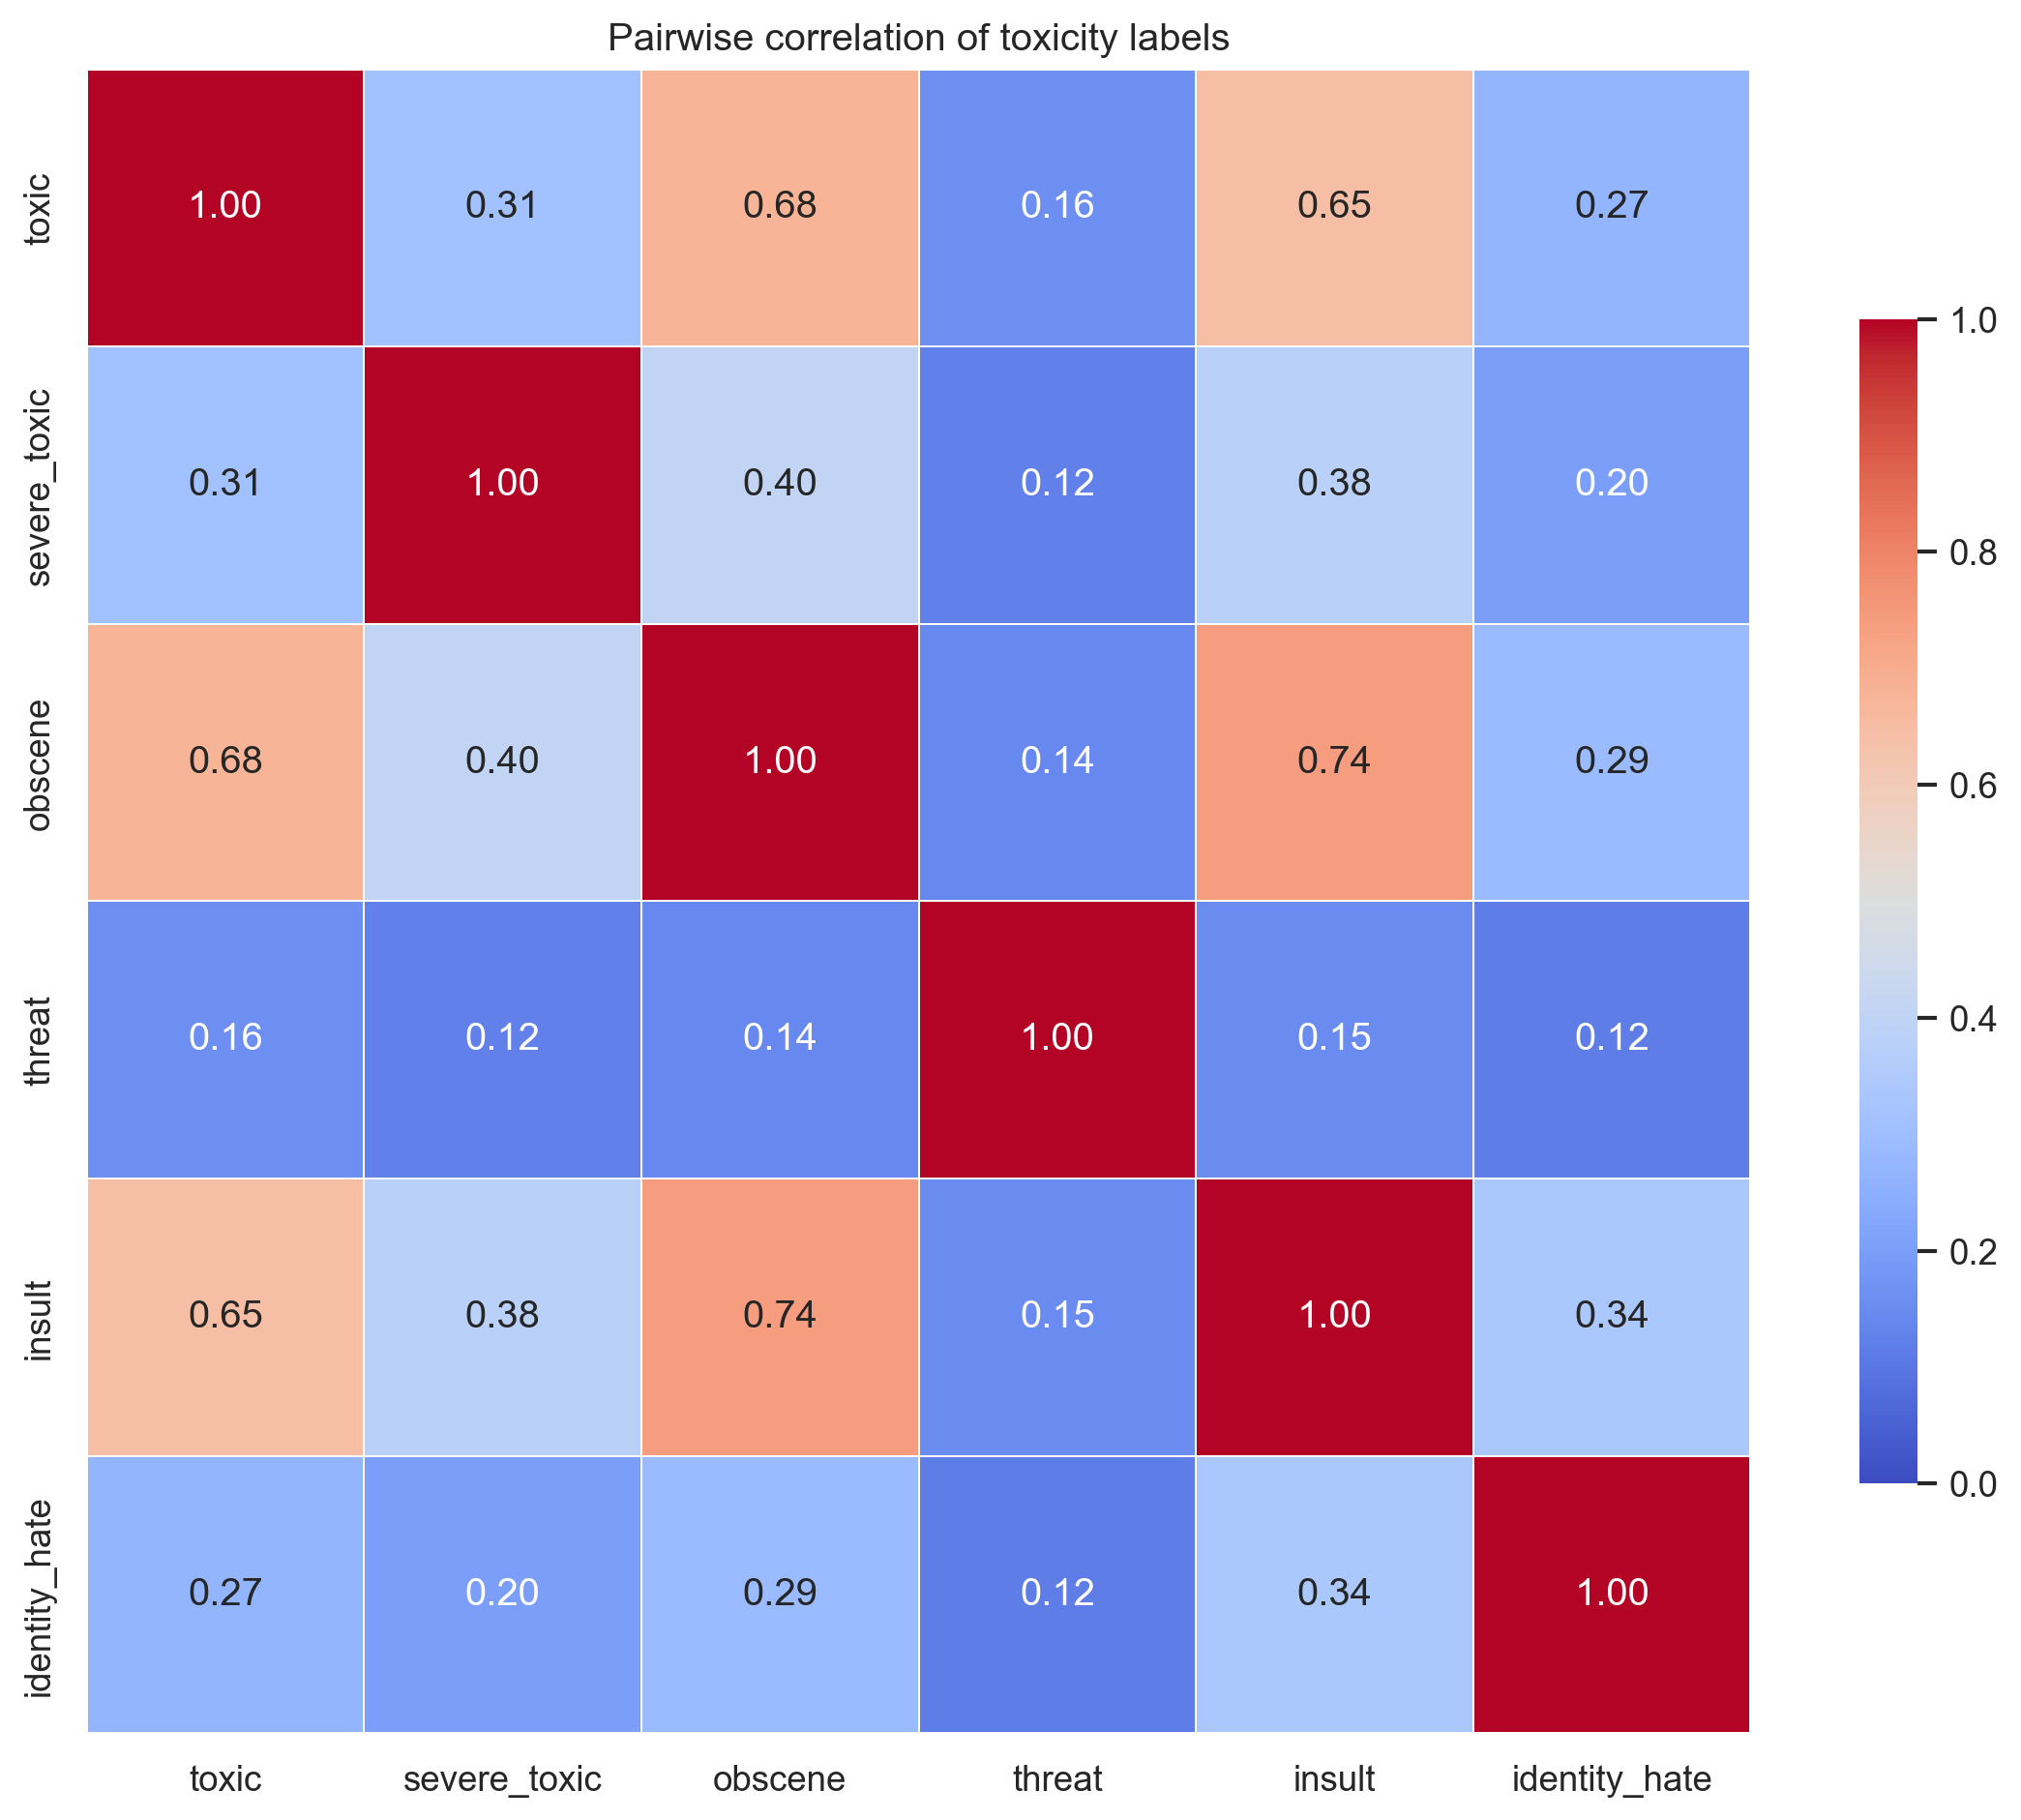

In [14]:
corr = df[label_cols].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr,
            annot=True, fmt='.2f',
            cmap='coolwarm',
            vmin=0, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink":.7})
plt.title("Pairwise correlation of toxicity labels")
plt.tight_layout()
plt.show()

In [15]:
# Find highly correlated pairs
print("Highly correlated category pairs (correlation > 0.5):")
high_corr_pairs = []
for i in range(len(label_cols)):
    for j in range(i+1, len(label_cols)):
        corr_val = corr.iloc[i, j]
        if corr_val > 0.5:
            high_corr_pairs.append((label_cols[i], label_cols[j], corr_val))
            print(f"  {label_cols[i]} - {label_cols[j]}: {corr_val:.3f}")

Highly correlated category pairs (correlation > 0.5):
  toxic - obscene: 0.677
  toxic - insult: 0.648
  obscene - insult: 0.741


### Comment length analysis

Lastly, the distribution of the lengths of the comments (considering the number of words) is explored, first overall and then by category.

In [16]:
# Calculate comment length (in words)
df['word_count'] = df['comment_text'].str.split().apply(len)

In [17]:
df[['comment_text','word_count']].head()

,comment_text,word_count
0,Explanation\nWhy the edits made under my usern...,43
1,D'aww! He matches this background colour I'm s...,17
2,"Hey man, I'm really not trying to edit war. It...",42
3,"""\nMore\nI can't make any real suggestions on ...",113
4,"You, sir, are my hero. Any chance you remember...",13


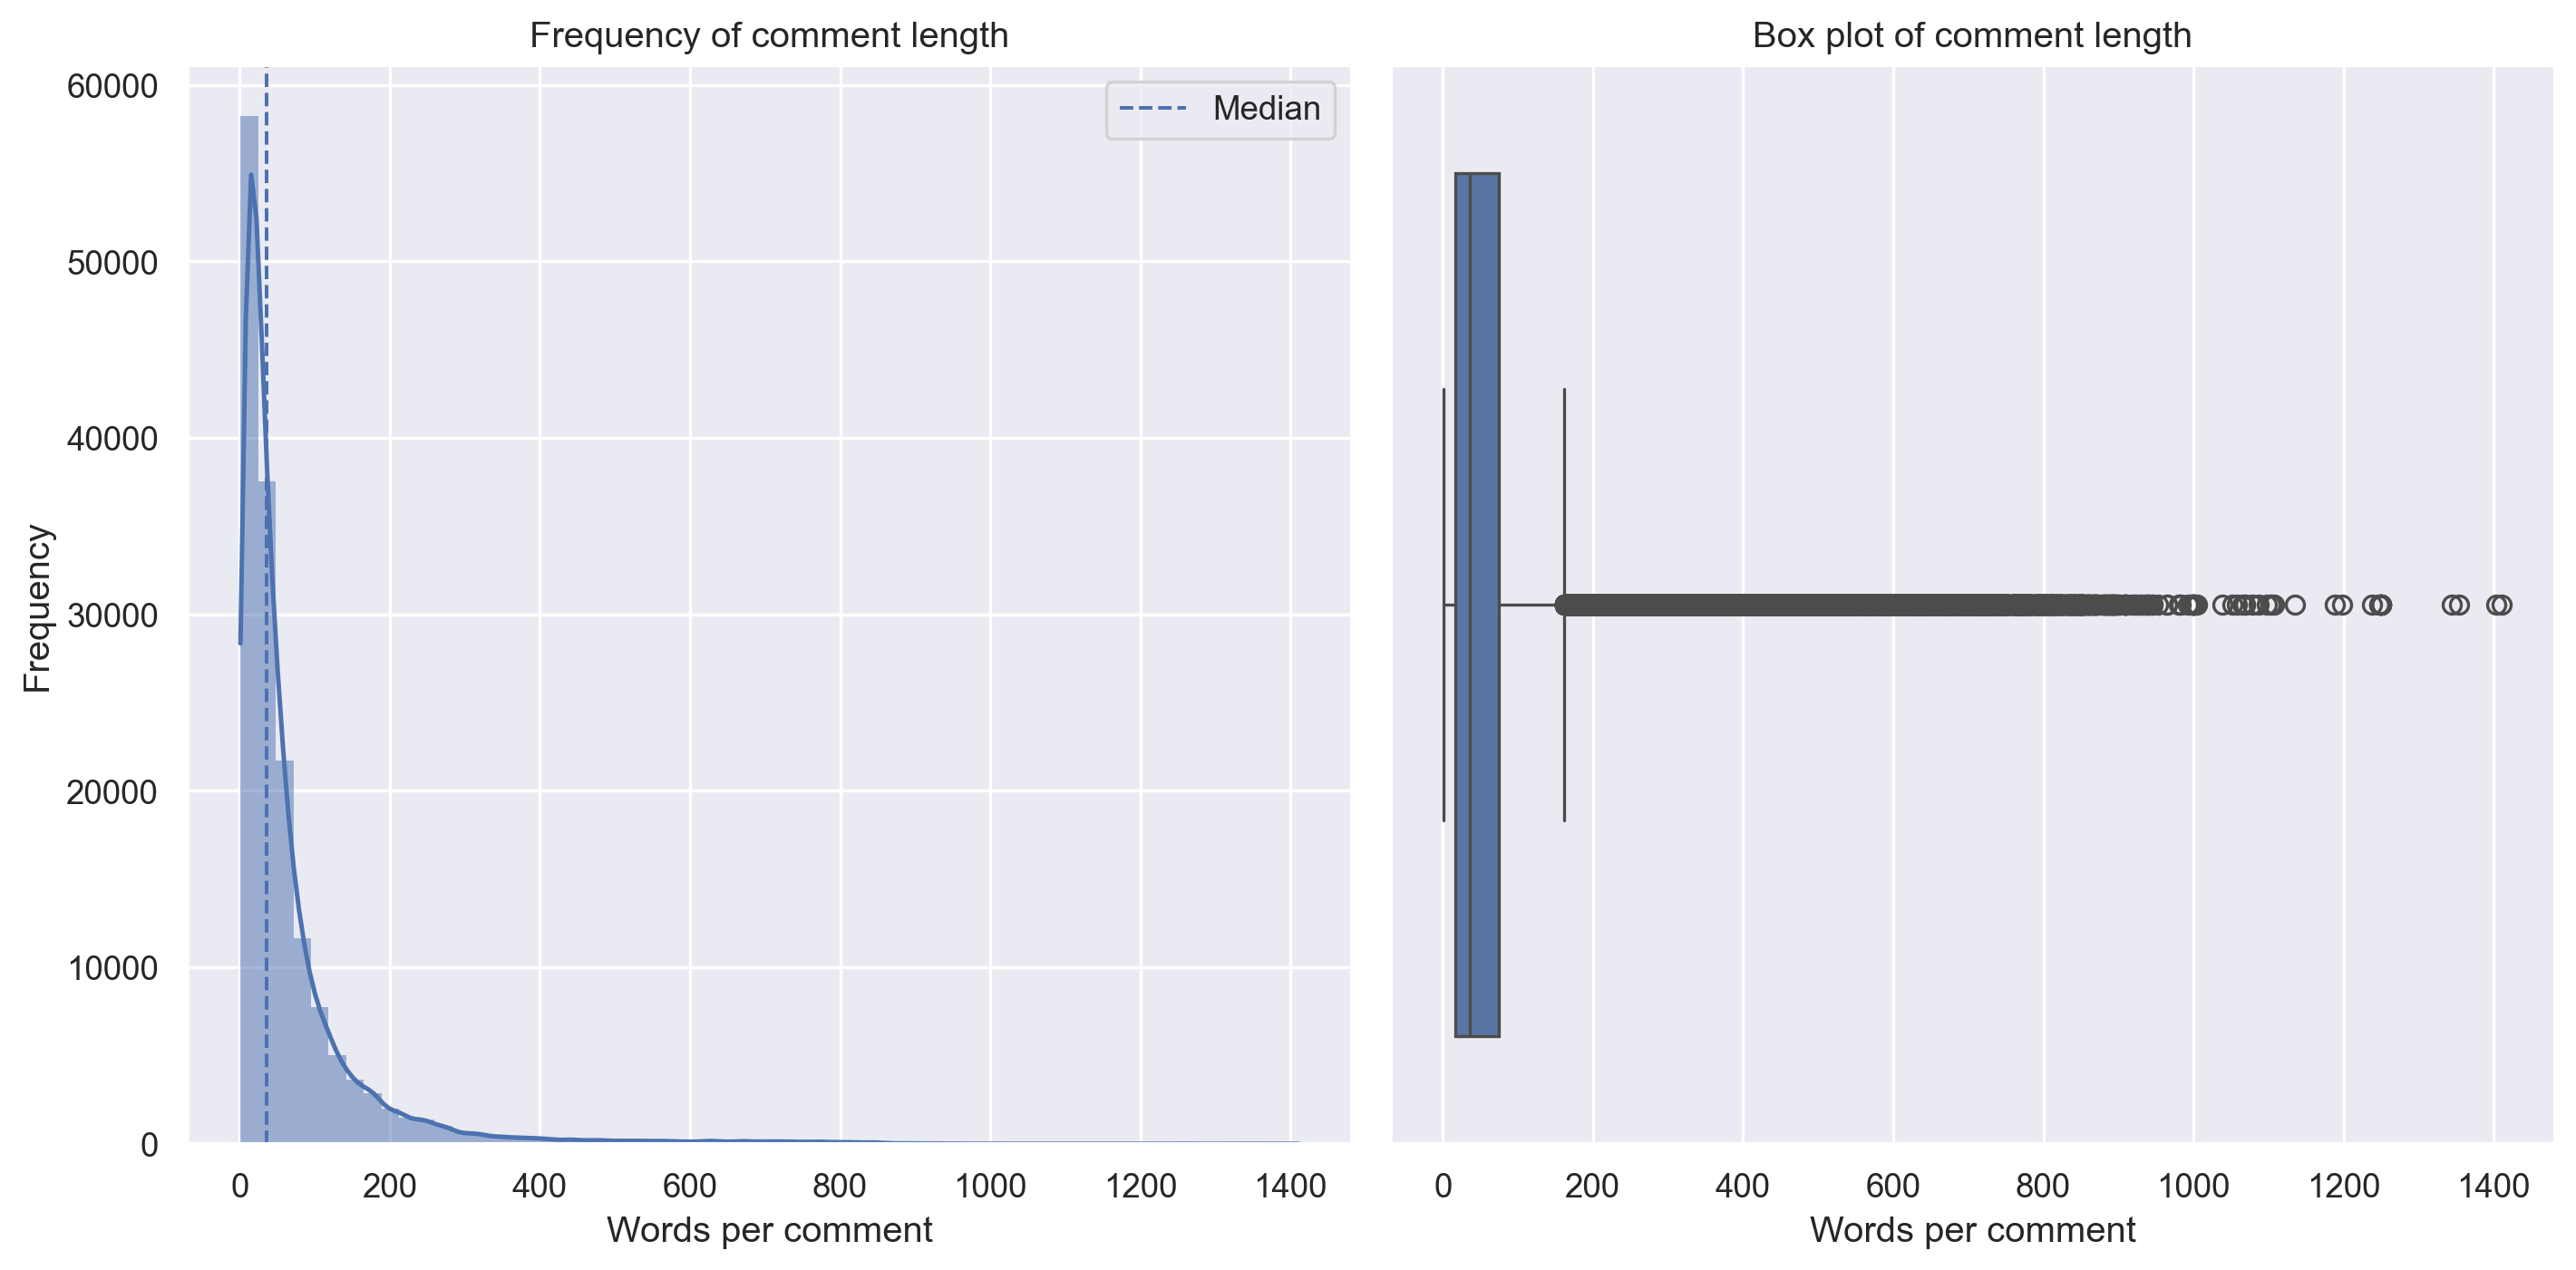

In [18]:
# Overall distribution

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=60, kde=True, edgecolor='none')
plt.axvline(df['word_count'].median(), ls='--', lw=1.2, label='Median')
plt.xlabel("Words per comment")
plt.ylabel("Frequency")
plt.title("Frequency of comment length")
plt.legend()

plt.subplot(1, 2, 2)
bp = sns.boxplot(df['word_count'], orient="y")
plt.xlabel("Words per comment")
plt.title("Box plot of comment length")

plt.tight_layout()
plt.show()

In [19]:
# Calculate lenght distribution statistics
df_len_stats = df['word_count'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_len_stats

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
50%          36.000000
75%          75.000000
90%         152.000000
95%         230.000000
99%         567.000000
max        1411.000000
Name: word_count, dtype: float64

In [20]:
df_words_melted = df.melt(value_vars=label_cols, id_vars='word_count',
                          var_name='label', value_name='is_present')
df_words_melted

,word_count,label,is_present
0,43,toxic,0
1,17,toxic,0
2,42,toxic,0
3,113,toxic,0
4,13,toxic,0
...,...,...,...
957421,47,identity_hate,0
957422,18,identity_hate,0
957423,12,identity_hate,0
957424,25,identity_hate,0


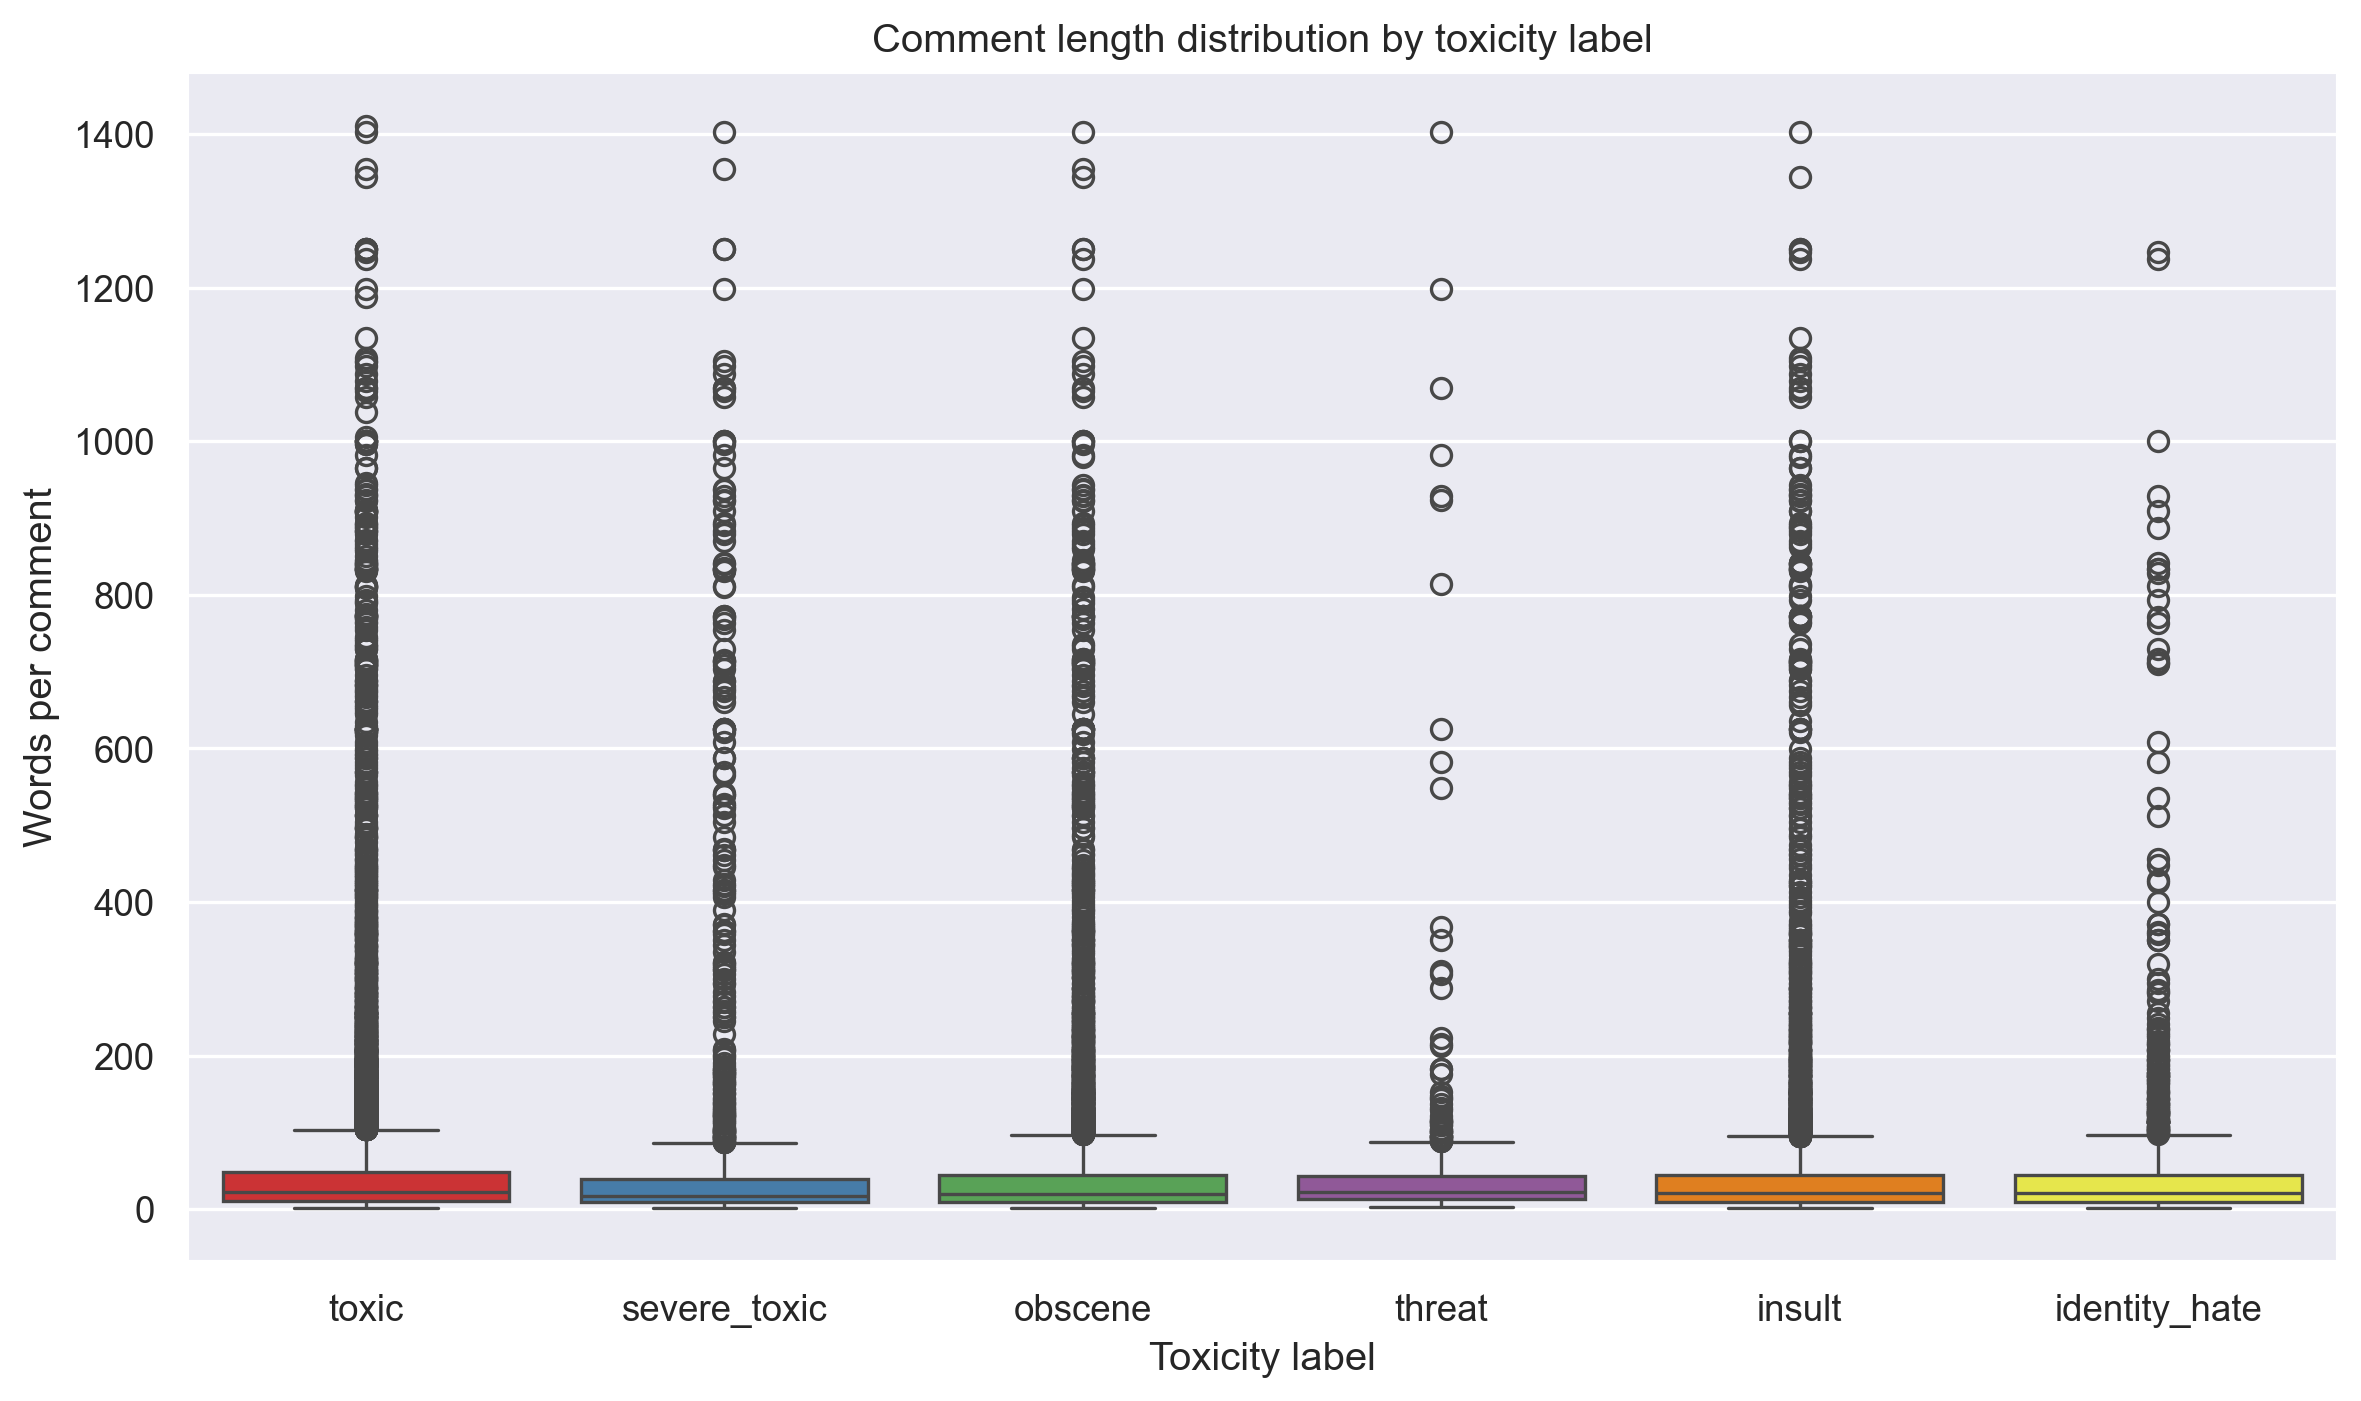

In [21]:
# Box Plots of Length by toxicity label
plt.figure(figsize=(10,6))
sns.boxplot(data=df_words_melted[df_words_melted["is_present"]==1],
            x='label', y='word_count',
            showfliers=True, hue='label', palette='Set1')
plt.xlabel("Toxicity label")
plt.ylabel("Words per comment")
plt.title("Comment length distribution by toxicity label")
plt.tight_layout()
plt.show()

In [22]:
# Calculate lenght distribution statistics by toxicity label
df_len_stats_labels = df_words_melted[df_words_melted["is_present"]==1].groupby('label')['word_count'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_len_stats_labels

label,identity_hate,insult,obscene,severe_toxic,threat,toxic
count,1405.000000,7877.000000,8449.000000,1595.000000,478.000000,15294.000000
mean,52.014235,48.269265,49.560540,75.620690,55.165272,51.289787
std,114.010570,107.678318,108.619102,186.184104,137.911176,106.475663
min,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000
50%,21.000000,21.000000,20.000000,17.000000,23.000000,22.000000
75%,45.000000,44.000000,45.000000,40.000000,43.000000,48.000000
90%,105.200000,92.000000,96.000000,142.200000,95.000000,102.000000
95%,178.000000,151.000000,162.000000,473.800000,143.300000,171.000000
99%,728.520000,703.000000,678.120000,982.900000,924.380000,654.210000
max,1247.000000,1403.000000,1403.000000,1403.000000,1403.000000,1411.000000


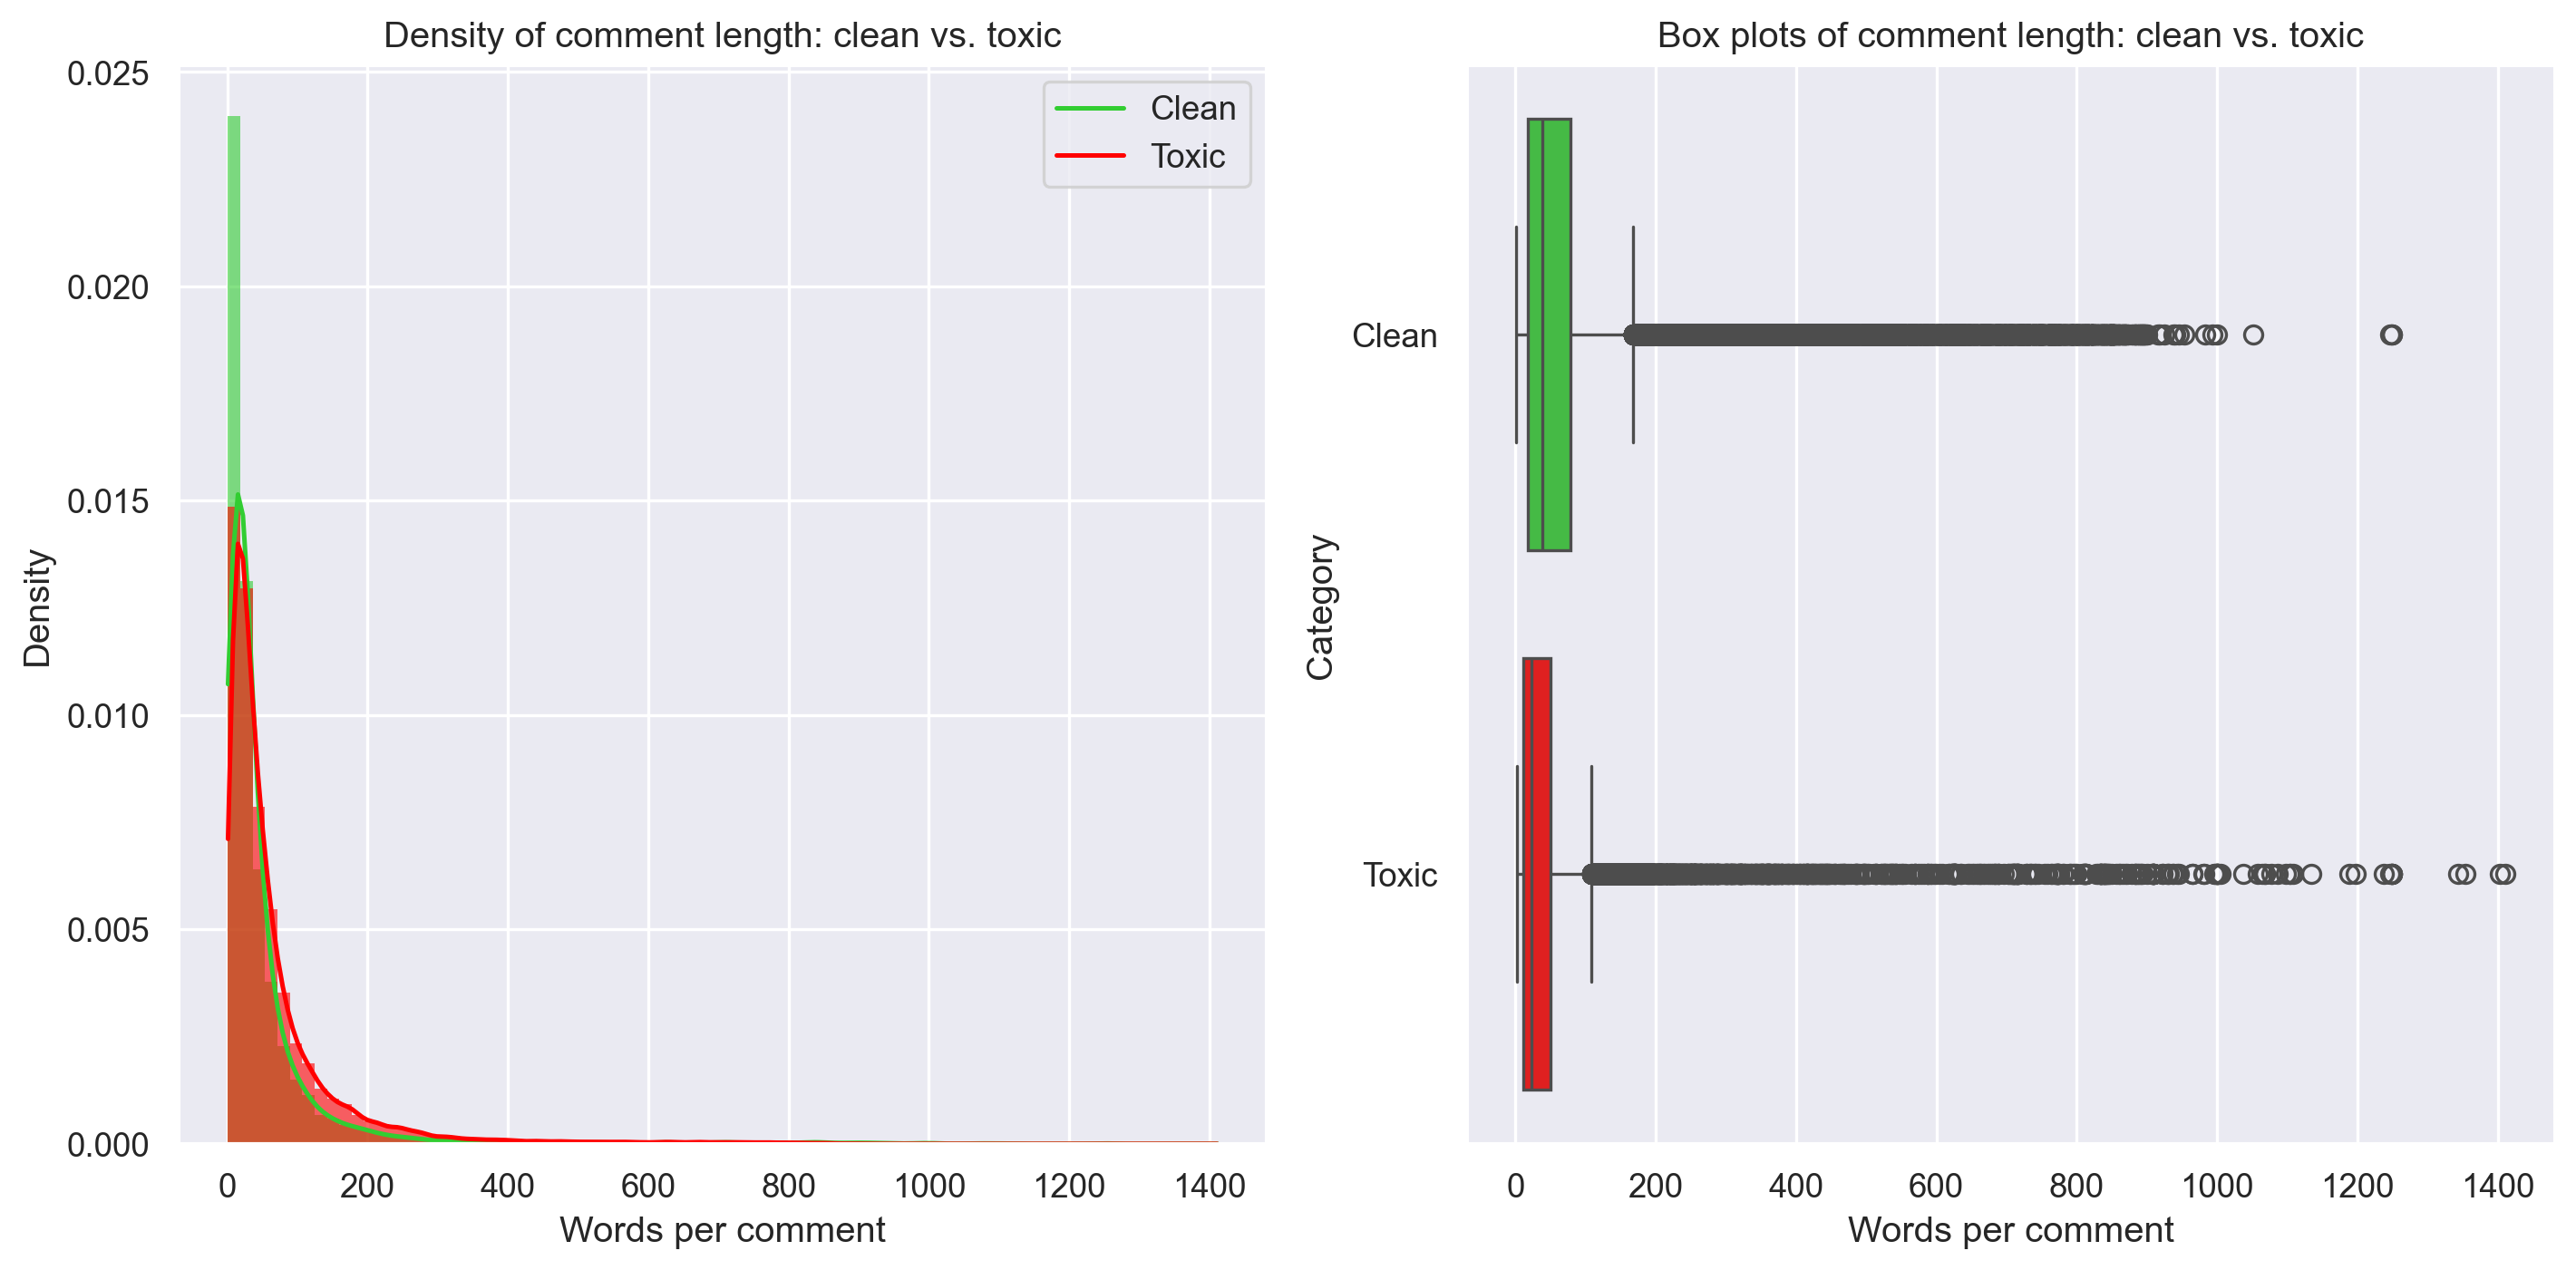

In [23]:
# Length distribution of clean vs toxic comments
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='word_count', hue='has_toxicity', palette=['red','limegreen'], bins=80,
             kde=True, stat='density', common_norm=False, edgecolor='none', alpha=.6)
plt.xlabel("Words per comment")
plt.title("Density of comment length: clean vs. toxic")
plt.legend(title='', labels=['Clean', 'Toxic'])

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='word_count', y='has_toxicity', orient="y", hue='has_toxicity',
            palette=['limegreen','red'], legend=False)
plt.xlabel("Words per comment")
plt.ylabel("Category")
plt.yticks([0,1], ['Clean', 'Toxic'])
plt.title("Box plots of comment length: clean vs. toxic")

plt.tight_layout()
plt.show()

In [24]:
# Calculate lenght distribution statistics of clean vs toxic comments
df_len_stats_toxicity = df.groupby('has_toxicity')['word_count'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_len_stats_toxicity

has_toxicity,False,True
count,143346.000000,16225.000000
mean,68.921065,52.717720
std,98.195083,106.854731
min,1.000000,2.000000
50%,38.000000,23.000000
75%,78.000000,50.000000
90%,156.000000,106.000000
95%,235.000000,176.000000
99%,562.000000,656.280000
max,1250.000000,1411.000000


## 2) Data preprocessing

In this phase, several cleaning and transformation methods are applied to the dataset in order to be properly processed by the Recurrent Neural Network.

### Cleaning of raw text

First, a basic text cleaning is perfomed, including the elimination of stop words, digits and control characters, which are assumed to be not informative for this task.

In [60]:
# Download the list of stop words
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
# Define a cleaning function to be applied to the comment text

def clean_text(text):

    # Remove digits and control characters
    text = re.sub(r"[\d\r\t\n]+", " ", text)

    # Drop stop-words (lowercase conversion for case-insensitive match)
    words = [w for w in text.split() if w.lower() not in STOPWORDS]

    return " ".join(words)

In [62]:
# Clean the comment text column
df['comment_clean'] = df['comment_text'].apply(clean_text)

# Re-compute word counts on the cleaned column
df['word_count_clean'] = df['comment_clean'].str.split().apply(len)

In [63]:
# Comment lenght statistics before and after cleaning
df_len_stats = df[['word_count', 'word_count_clean']].describe(percentiles=[.50, .75, .90, .95, .99])
df_len_stats

,word_count,word_count_clean
count,159571.000000,159571.000000
mean,67.273527,36.932845
std,99.230702,56.233155
min,1.000000,0.000000
50%,36.000000,20.000000
75%,75.000000,40.000000
90%,152.000000,82.000000
95%,230.000000,123.000000
99%,567.000000,315.000000
max,1411.000000,1250.000000


### Train / Test split with multilabel stratification

Here, the dataset is split into train/test sets, using *MultilabelStratifiedShuffleSplit* from the [**iterative-stratification**](https://github.com/trent-b/iterative-stratification) package, which allows to stratify multilabel data.

In [64]:
# Assign the comment text and label columns to the X,y variables
X = df['comment_clean'].values
y = df[label_cols].values

print(f"Dataset shape before splitting: \n X: {X.shape} \n y: {y.shape}")

Dataset shape before splitting: 
 X: (159571,) 
 y: (159571, 6)


In [65]:
# Apply multilabel stratified train/test split
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in msss.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

print(f"Train dataset size: {X_train.shape[0]} samples\nTest dataset size: {X_test.shape[0]} samples")

Train dataset size: 127656 samples
Test dataset size: 31915 samples


In [66]:
split = [("train", y_train), ("test", y_test)]
for ds, y in split:
    df_y = pd.DataFrame(y)
    df_y['sum_injurious'] = df_y.sum(axis=1)
    df_y['has_toxicity'] = (df_y["sum_injurious"] > 0)
    clean_toxic_count_y = df_y['has_toxicity'].value_counts().rename({False: 'clean', True: '≥1 toxic label'})
    clean_toxic_pct_y = df_y['has_toxicity'].value_counts(normalize=True).rename({False: 'clean', True: '≥1 toxic label'}) * 100

    print(f"Distribution of clean vs toxic comments ({ds} dataset):")
    print(f"  Clean: {clean_toxic_count_y.iloc[0]} comments ({clean_toxic_pct_y.iloc[0]:.2f}%)")
    print(f"  With toxicity: {clean_toxic_count_y.iloc[1]} comments ({clean_toxic_pct_y.iloc[1]:.2f}%)\n")

Distribution of clean vs toxic comments (train dataset):
  Clean: 114660 comments (89.82%)
  With toxicity: 12996 comments (10.18%)

Distribution of clean vs toxic comments (test dataset):
  Clean: 28686 comments (89.88%)
  With toxicity: 3229 comments (10.12%)



### Vectorization to sequences of integers

Here, all comment samples are vectorized, namely converted from text into integer sequences, which can be used as input for the neural network model. The sequences consists of lists of token indices from a vocabulary created from the dataset. For this process, [*TextVectorization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) from *tf.keras.layers* will be used. This layer is designed to handle natural language inputs for Tensorflow Keras models.

While the vocabulary is built directly from the text dataset, it can be capped to a maximum size, which in this case will be set to a number covering 90% of words occurrence in the dataset. Moreover, the length of the output sequences will be set to the 95th percentile of comments length. Text inputs of lower and higher lengths are padded or truncated, resulting in a standardized output dimension.

In [67]:
# Calculate the vocabulary size that covers 90% of word occurrences
word_counts = Counter(" ".join(X_train).split())
tot_words  = sum(word_counts.values())
cum, vocab_size = 0, 0
for tok, freq in word_counts.most_common():
    cum += freq
    vocab_size += 1
    if cum / tot_words >= 0.90:
        break

In [68]:
print(f"Total words in the dataset: {tot_words}")
print(f"Unique words in the dataset: {len(word_counts)}")
print(f"Size of the vocabulary covering 90% of word occurrences: {vocab_size}")

Total words in the dataset: 4719192
Unique words in the dataset: 431456
Size of the vocabulary covering 90% of word occurrences: 69878


In [69]:
# Convert train and test datasets from text to integer sequences (vectorization)

# Set the sequence length to 95th percentile of comments length
SEQ_LEN = int(df_len_stats.loc["95%", "word_count"])

# Create the vectorizer layer
vectorizer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_sequence_length=SEQ_LEN,
    output_mode='int'
)

# Build the vocabulary based on the text dataset
vectorizer.adapt(X_train)

# Convert text to sequences of integers
X_train_seq = vectorizer(X_train).numpy()
X_test_seq  = vectorizer(X_test).numpy()

In [70]:
# Visualize examples of original comment text and the corresponding sequence
for i in range(5):
    print(f"Comment: {' '.join(X_train[i].split()[:12])} ...")
    print(f"Sequence: {X_train_seq[i][:12]} ...\n")

Comment: Explanation edits made username Hardcore Metallica Fan reverted? vandalisms, closure GAs voted ...
Sequence: [  542    47    50   541  4516 12019   941   218 11108  6582  2701  2639] ...

Comment: Hey man, really trying edit war. guy constantly removing relevant information talking ...
Sequence: [ 311  340   52  143   16  219  484 2089  385  376   27  463] ...

Comment: " can't make real suggestions improvement - wondered section statistics later on, ...
Sequence: [ 107   25  243 1269 1964 5397   44 2275  388  400 3403 1147] ...

Comment: You, sir, hero. chance remember page that's on? ...
Sequence: [  19 1552 3386  890  450    3   88  400    0    0    0    0] ...

Comment: COCKSUCKER PISS AROUND WORK ...
Sequence: [1419 3273  216   60    0    0    0    0    0    0    0    0] ...



In [71]:
print("Sequence feature matrix shapes:")
print(f"  Train: {X_train_seq.shape}")
print(f"  Test:  {X_test_seq.shape}")

Sequence feature matrix shapes:
  Train: (127656, 230)
  Test:  (31915, 230)


### Balancing of the training dataset

The task addressed by this project is a **multilabel classification**, where the target variable has more than one dimension and each dimension is binary (contains only two distinct values). Moreover, as observed in the exploratory analysis, the labels are unevenly distributed among classes. This problem of **data imbalance** can greatly affect the performance of the deep learning algorithm.

To overcome data imbalance, the approach of **data augmentation** can be used. ***Multi label Synthetic Minority Over-sampling Technique*** ([**MLSMOTE**](https://github.com/niteshsukhwani/MLSMOTE)) is a method of data augmentation for imbalanced multilabel data. The general approach of MLSOMTE is the following: data with minority class labels are selected; for each data point the k-nearest neighbours are found; synthetic data points are generated anywhere on the line joining the original data point and a random point in the k-nearest neighbours.

Here, the MSMOTE algorithm will be used to balance the different toxicity classes of the training dataset by augmenting classes with minority labels (or *tail* labels). Then, the augmented dataset with toxicity classes will be be combined with an equal-size subset of *clean* data (with no toxicity labels), to obtain a balanced number of *clean* vs *toxic* samples. The test dataset will not be modified, to evaluate the performance of the deep learning classification model with a realistic distribution of classes.

In [72]:
# Download mlsmote.py and import the file as a Python module to use the embedded functions
if not os.path.exists("mlsmote.py"):
    url = ("https://raw.githubusercontent.com/niteshsukhwani/MLSMOTE/refs/heads/master/mlsmote.py")
    with open("mlsmote.py", "wb") as f:
        f.write(requests.get(url, timeout=15).content)

import mlsmote

In [73]:
# Convert the integer-sequence matrix to a DataFrame
seq_cols = [f"tok_{i}" for i in range(SEQ_LEN)]
X_train_df = pd.DataFrame(X_train_seq, columns=seq_cols)
y_train_df = pd.DataFrame(y_train, columns=label_cols)

In [74]:
# Define a function to calculate the distribution (count + percentage) of clean vs toxic (overall)
# and toxicity labels

def calculate_toxicity_distribution(y_df, verbose=True):

    clean_count = (y_df.sum(axis=1) == 0).sum()
    toxic_count = len(y_df) - clean_count

    y_counts_df = y_df.sum().sort_values(ascending=False).rename('count').to_frame()
    y_counts_df['%'] = y_counts_df['count'].div(y_counts_df['count'].sum()).mul(100).round(2)
    y_counts_df['%_total_toxic'] = y_counts_df['count'].div(toxic_count).mul(100).round(2)

    if verbose == True:
        print(f"\n  Total clean comments: {clean_count} ({clean_count/len(y_df)*100:.1f}%)")
        print(f"  Total toxic comments: {toxic_count} ({toxic_count/len(y_df)*100:.1f}%)")
        print("\n  Toxicity labels distribution:")
    return clean_count, toxic_count, y_counts_df

In [75]:
print("Distribution of the original training dataset:")
clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_train_df)
y_counts_df

Distribution of the original training dataset:

  Total clean comments: 114660 (89.8%)
  Total toxic comments: 12996 (10.2%)

  Toxicity labels distribution:


,count,%,%_total_toxic
toxic,12235,43.58,94.14
obscene,6759,24.07,52.01
insult,6302,22.44,48.49
severe_toxic,1276,4.54,9.82
identity_hate,1124,4.00,8.65
threat,382,1.36,2.94


In [76]:
# Get a minority subset of the training dataset containing all the tail labels
X_min, y_min = mlsmote.get_minority_instace(X_train_df, y_train_df)

In [77]:
print("Minority subset shapes:")
print(f"  Minority X: {X_min.shape}")
print(f"  Minority y:  {y_min.shape}")

Minority subset shapes:
  Minority X: (2397, 230)
  Minority y:  (2397, 6)


In [78]:
print("Distribution of the minority subset:")
clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_min)
y_counts_df

Distribution of the minority subset:

  Total clean comments: 0 (0.0%)
  Total toxic comments: 2397 (100.0%)

  Toxicity labels distribution:


,count,%,%_total_toxic
toxic,2289,25.76,95.49
obscene,1919,21.60,80.06
insult,1896,21.34,79.10
severe_toxic,1276,14.36,53.23
identity_hate,1124,12.65,46.89
threat,382,4.30,15.94


The aim is to obtain a training dataset of the same size as the original but with a 50% ditribution of *clean* vs *toxic* comments. Since the minority subset contains 0 *clean* comments, the number of synthetic samples to generate will be 50% of the original dataset subtracted with the length of the minority subset.

In [79]:
# Calculate how many synthetic samples to generate for a balanced dataset (50% clean, 50% toxic)

target_ratio = 0.5

total_samples_needed = y_train.shape[0]
samples_to_generate = int(total_samples_needed * target_ratio) - y_min.shape[0]

print(f"  Target total samples: {total_samples_needed}")
print(f"  Samples to generate: {samples_to_generate}")

  Target total samples: 127656
  Samples to generate: 61431


In [80]:
# Get augmented data using MLSMOTE algorithm
X_aug, y_aug = mlsmote.MLSMOTE(X_min, y_min, samples_to_generate)

In [81]:
print("Augmented dataset shapes:")
print(f"  Augmented X: {X_aug.shape}")
print(f"  Augmented y:  {y_aug.shape}")

Augmented dataset shapes:
  Augmented X: (63828, 230)
  Augmented y:  (63828, 6)


In [82]:
print("Distribution of augmented dataset:")
clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_aug)
y_counts_df

Distribution of augmented dataset:

  Total clean comments: 0 (0.0%)
  Total toxic comments: 63828 (100.0%)

  Toxicity labels distribution:


,count,%,%_total_toxic
toxic,63720.0,25.72,99.83
obscene,59812.0,24.14,93.71
insult,58809.0,23.74,92.14
severe_toxic,37420.0,15.10,58.63
identity_hate,25307.0,10.22,39.65
threat,2669.0,1.08,4.18


In [83]:
# Combine the augmented dataset with an equal-size clean subset

# Select a random sample of original clean data
clean_idx_all = np.where(y_train_df.sum(axis=1) == 0)[0]
clean_samples_needed = int(total_samples_needed * target_ratio)
clean_idx_sel = np.random.choice(clean_idx_all, size=clean_samples_needed)

# Extract a clean subset of original dataset
X_clean_seq = X_train_seq[clean_idx_sel]
y_clean = y_train[clean_idx_sel]

# Assemble the balanced training dataset
X_train_bal_seq = np.vstack([X_clean_seq, X_aug.values])
y_train_bal = np.vstack([y_clean, y_aug.values])

This augmentation method results in continuous feature vectors containing floats values, some of which outside the interval of the original vectorized dataset (0 - *vocab. size*). This will cause errors with the *Embedding* layer in the model, so the generated values are rounded to the nearest integer and clipped to the original interval edges.

In [ ]:
print(f"Augmented dataset interval: {X_train_bal_seq.min()} - {X_train_bal_seq.max()}")

# Round and clip to the interval 0 - vocab_sz
X_train_bal_seq = np.clip(np.rint(X_train_bal_seq), 0, vocab_size).astype(np.int32)
print(f"Augmented dataset interval (corrected): {X_train_bal_seq.min()} - {X_train_bal_seq.max()}")

Augmented dataset interval: -63772.67911662262 - 137329.54502518306
Augmented dataset interval (corrected): 0 - 69878


In [85]:
y_train_bal_df = pd.DataFrame(y_train_bal, columns=label_cols)

print(f"Balanced training datset size: {X_train_bal_seq.shape[0]} samples, {X_train_bal_seq.shape[1]} features")
print("\nDistribution of balanced training dataset:")
clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_train_bal_df)
y_counts_df

Balanced training datset size: 127656 samples, 230 features

Distribution of balanced training dataset:

  Total clean comments: 63828 (50.0%)
  Total toxic comments: 63828 (50.0%)

  Toxicity labels distribution:


,count,%,%_total_toxic
toxic,63720.0,25.72,99.83
obscene,59812.0,24.14,93.71
insult,58809.0,23.74,92.14
severe_toxic,37420.0,15.10,58.63
identity_hate,25307.0,10.22,39.65
threat,2669.0,1.08,4.18


In [86]:
datasets = {
    "Original": (X_train_seq, y_train),
    "Balanced": (X_train_bal_seq, y_train_bal)
}

In [87]:
for i, dataset in enumerate(datasets.keys()):

    y_dataframe = pd.DataFrame(datasets[dataset][1], columns=label_cols)
    clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_dataframe, verbose=False)
    print(f"{dataset} label distribution:")
    display(y_counts_df)

Original label distribution:


,count,%,%_total_toxic
toxic,12235,43.58,94.14
obscene,6759,24.07,52.01
insult,6302,22.44,48.49
severe_toxic,1276,4.54,9.82
identity_hate,1124,4.00,8.65
threat,382,1.36,2.94


Balanced label distribution:


,count,%,%_total_toxic
toxic,63720.0,25.72,99.83
obscene,59812.0,24.14,93.71
insult,58809.0,23.74,92.14
severe_toxic,37420.0,15.10,58.63
identity_hate,25307.0,10.22,39.65
threat,2669.0,1.08,4.18


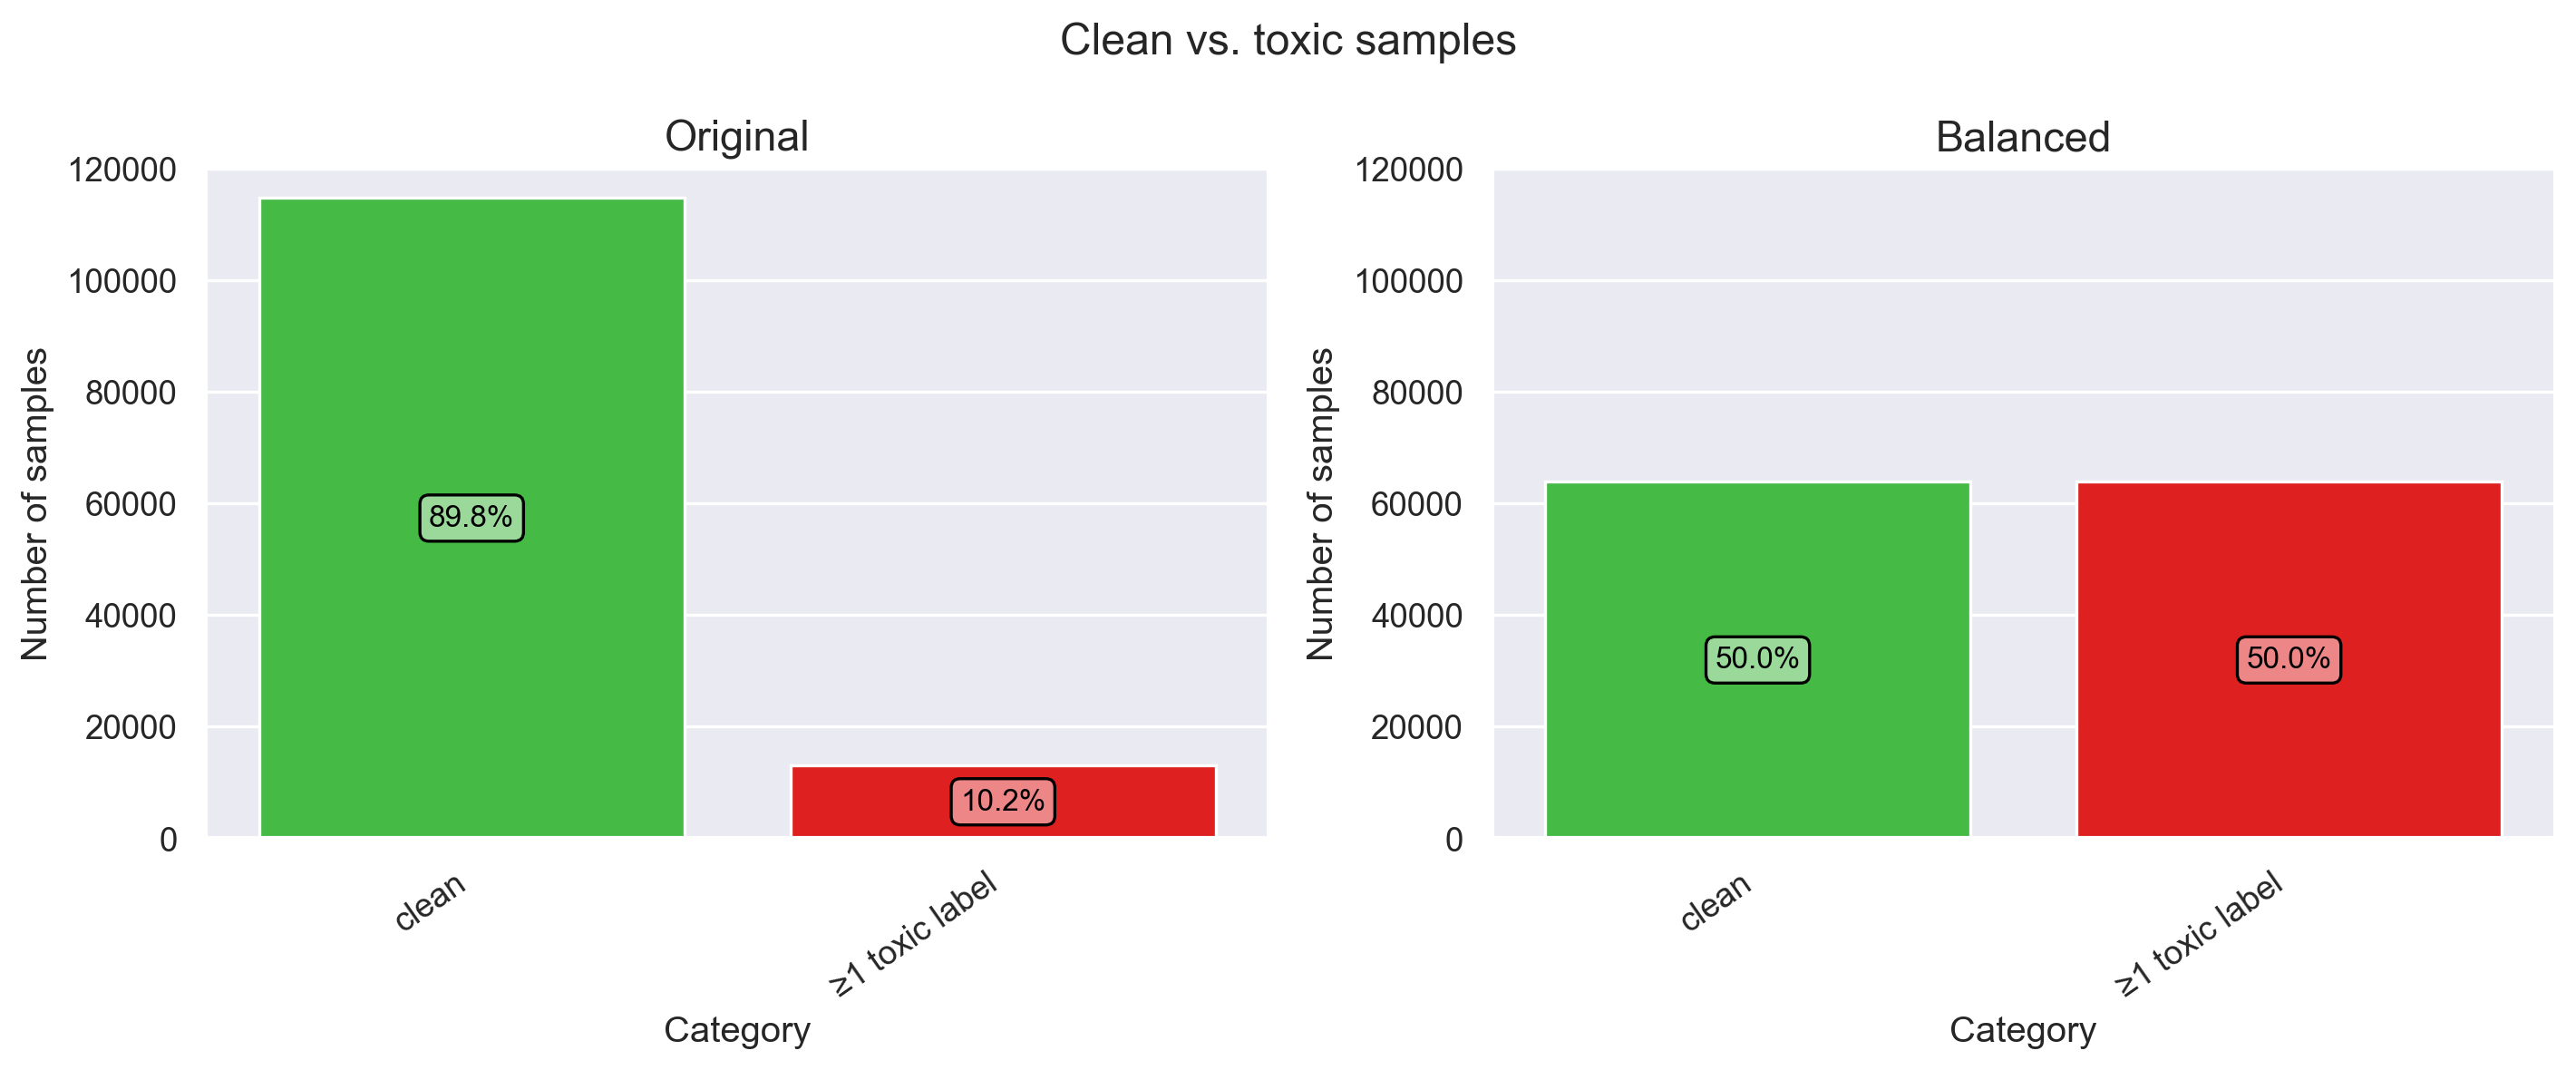

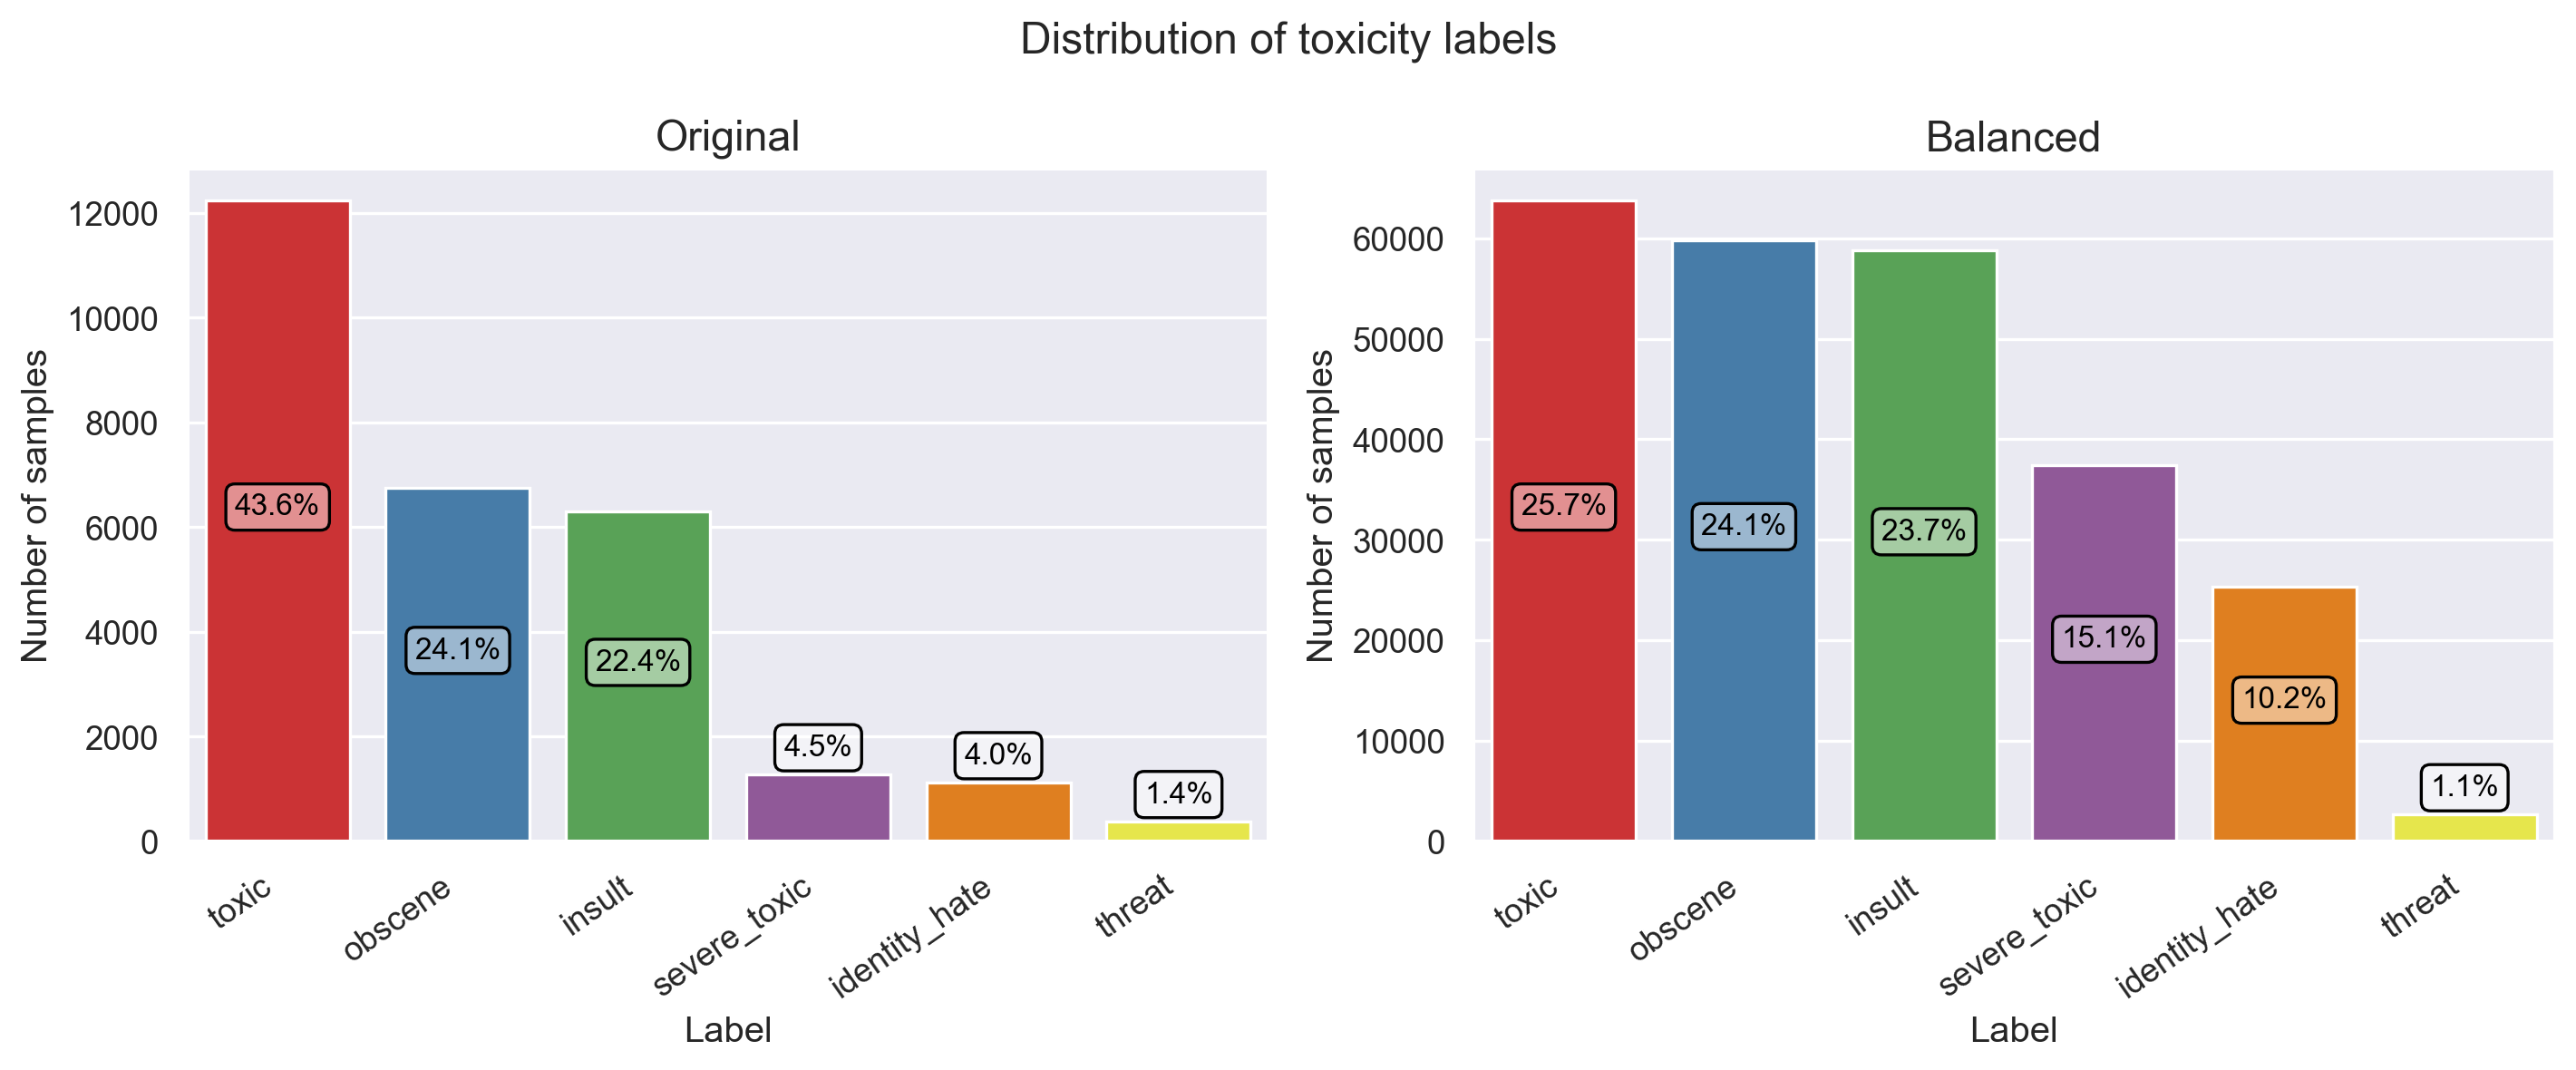

In [88]:
# Bar plots of toxicity presence in samples

plt.figure(figsize=(12, 5))

for i, dataset in enumerate(datasets.keys()):

    y_dataframe = pd.DataFrame(datasets[dataset][1], columns=label_cols)
    clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_dataframe, verbose=False)

    plt.subplot(1, 2, i+1)
    sns.barplot(x=['clean', '≥1 toxic label'], y=[clean_count, toxic_count], hue=['clean', '≥1 toxic label'], palette=['limegreen', 'red'])
    plt.ylim(0, 120000)
    plt.xlabel("Category")
    plt.ylabel("Number of samples")
    plt.title(dataset, fontsize=14)
    plt.xticks(rotation=35, ha='right')

    for i, count in enumerate([clean_count, toxic_count]):
        plt.annotate(f"{count/len(y_dataframe)*100:.1f}%",
                     xy=(i, count/2),
                     ha='center', va='center', fontsize=10, color='black',
                     bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.suptitle("Clean vs. toxic samples")
plt.tight_layout()
plt.show()


# Bar plots of toxicity labels distribution

plt.figure(figsize=(12, 5))

for i, dataset in enumerate(datasets.keys()):

    y_dataframe = pd.DataFrame(datasets[dataset][1], columns=label_cols)
    clean_count, toxic_count, y_counts_df = calculate_toxicity_distribution(y_dataframe, verbose=False)
    y_counts_df = y_counts_df.reindex(['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate','threat'])

    plt.subplot(1, 2, i+1)
    bars = sns.barplot(x=y_counts_df.index, y=y_counts_df['count'], hue=y_counts_df.index, palette="Set1")

    bar_max = y_counts_df['count'].max()

    for bar, pct in zip(bars.patches, y_counts_df['%']):
        bars.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height()/2 if bar.get_height()/2 > bar_max*.1 else bar.get_height() + 0.02 * bar_max,
            f'{pct:.1f}%',
            ha="center", va="bottom", fontsize=10, color="black",
            bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

    plt.xlabel("Label")
    plt.ylabel("Number of samples")
    plt.title(dataset, fontsize=14)
    plt.xticks(rotation=35, ha='right')

plt.suptitle("Distribution of toxicity labels")
plt.tight_layout()
plt.show()

As can be observed in the plots, after the balancing procedure, the clean and toxic samples are perfectly equally sized. The distribution of toxicity labels, resulting from the application of MLSMOTE algorithm, is more balanced respect to the original dataset, but some of the classes (particularly the "*threat*" class) are still minority, probably due to the relatively low number of original samples. The performance of the classification model for these classes will likely be lower respect to the more represented classes.

## 3) Model definition

In this phase, the Neural Network model is created and the training dataset is prepared for the model training.

### Creation of the Neural Network model

The defined Neural Network consists of a model with a deep learning architecture including a series of layer added in sequence, some of which specialized to process sequential data derived from text:
- the ***Input*** layer declares the expected shape of input samples, in this case a 1‑D sequence of integer tokens of fixed length;
- the ***Embedding*** layer maps integer tokens to embedding vectors of size 128 and include a masking to ensure that index 0 is treated as padding and ignored by recurrent layers in computations;
- the ***SpatialDropout1D*** layer has a regularization purpose, as it randomly drops entire embedding feature dimensions with probability 0.2 in order to prevent overfitting;
- a first ***Bidirectional*** layer processes the vector sequences from both directions to capture contextual features from both past and future tokens: in this case two ***GRU*** (*Gated Recurrent Unit*) layers, a type of recurrent neural network designed to overcome the vanishing gradient problem, take the inputs, one in a forward direction and the other in a backwards direction, and output sequences for a second recurrent layer;
- a second ***Bidirectional*** layer takes the sequence inputs from the previous layer and outputs single vector representations;
- a first ***Dense*** layer with a *relu* activation function transorms features and allows the model to learn non-linear patterns and relationships;
- the ***Dropout*** layer provides further regularization to mitigate overfitting;
- a final ***Dense*** layer with a *sigmoid* activation function outputs 6 independent probabilities (1 for each label), producing the multilabel classification.

In [ ]:
clear_session()

model = models.Sequential([
    layers.Input(shape=(SEQ_LEN,)),
    layers.Embedding(input_dim=vocab_size + 1,
                     output_dim=128,
                     mask_zero=True),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.GRU(64, return_sequences=True)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(6, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 230, 128)       │     8,952,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 230, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 230, 128)       │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,110,086 (34.75 MB)

 Trainable params: 9,110,086 (34.75 MB)

 Non-trainable params: 0 (0.00 B)

When compiling the model, the *'binary cross-entropy'* is selected as loss function, calculating the cross-entropy loss between true labels and predicted labels for binary (0 or 1) classification (as in this case there are independent binary targets for the 6 outputs). Then, the *'adam'* optimizer, a common adaptive learning rate optimizer using the Adam algorithm is selected. Lastly, four metrics are selected to evaluate the model performance during training and validation:
- ***Binary Accuracy***, computing the fraction of total labels whose predicted probability matches the true binary label;
- ***Precision***, computing the fraction of true positive labels over all labels predicted positive;
- ***Recall***, computing the fraction of predicted positive labels over all true positive labels;
- ***F1 Score***, computing the harmonic mean of precision and recall.

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(average="weighted", name='f1')
    ]
)

Here, an early stopping callback is defined to stop training when a monitored metric, in this case the validation loss, has stopped improving. The number of epochs with no improvement after which training stops is set to 3.

In [ ]:
# Early stopping on validation accuracy (restore best epoch)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

### Validation split

A validation dataset is split from the balanced training dataset (15%), using the MultilabelStratifiedShuffleSplit, and will be used as validation data in the training phase.

In [ ]:
msss_val = MultilabelStratifiedShuffleSplit(test_size=0.15, n_splits=1)

for tr_idx, val_idx in msss.split(X_train_bal_seq, y_train_bal):
   X_tr, X_val = X_train_bal_seq[tr_idx], X_train_bal_seq[val_idx]
   y_tr, y_val = y_train_bal[tr_idx], y_train_bal[val_idx]


In [ ]:
print("Final training size:", X_tr.shape,
      "\nValidation size:", X_val.shape)

Final training size: (102124, 230) 
Validation size: (25532, 230)


## 4) Model training

In this phase, the defined model is trained and the related learning curves tracking the peformance during training, based on the calculated metrics, are visualized.

In [ ]:
# Tensorflow dataset preparation

BATCH_SIZE = 32

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_ds(X_tr,  y_tr,  shuffle=True)
ds_val   = make_ds(X_val, y_val, shuffle=False)

In [ ]:
# Model training

EPOCHS = 5

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/5
3192/3192 - 3037s - 952ms/step - accuracy: 0.8303 - loss: 0.3636 - precision: 0.7726 - recall: 0.6715 - val_accuracy: 0.8496 - val_loss: 0.3207 - val_precision: 0.7891 - val_recall: 0.7283
Epoch 2/5
3192/3192 - 2978s - 933ms/step - accuracy: 0.8787 - loss: 0.2644 - precision: 0.8316 - recall: 0.7823 - val_accuracy: 0.8564 - val_loss: 0.3120 - val_precision: 0.8187 - val_recall: 0.7123
Epoch 3/5
3192/3192 - 3007s - 942ms/step - accuracy: 0.9069 - loss: 0.2089 - precision: 0.8648 - recall: 0.8430 - val_accuracy: 0.8557 - val_loss: 0.3340 - val_precision: 0.7901 - val_recall: 0.7521
Epoch 4/5
3192/3192 - 2840s - 890ms/step - accuracy: 0.9269 - loss: 0.1699 - precision: 0.8925 - recall: 0.8791 - val_accuracy: 0.8542 - val_loss: 0.3738 - val_precision: 0.7801 - val_recall: 0.7627
Epoch 5/5
3192/3192 - 2876s - 901ms/step - accuracy: 0.9412 - loss: 0.1396 - precision: 0.9131 - recall: 0.9036 - val_accuracy: 0.8499 - val_loss: 0.3999 - val_precision: 0.7635 - val_recall: 0.7742
Epoch

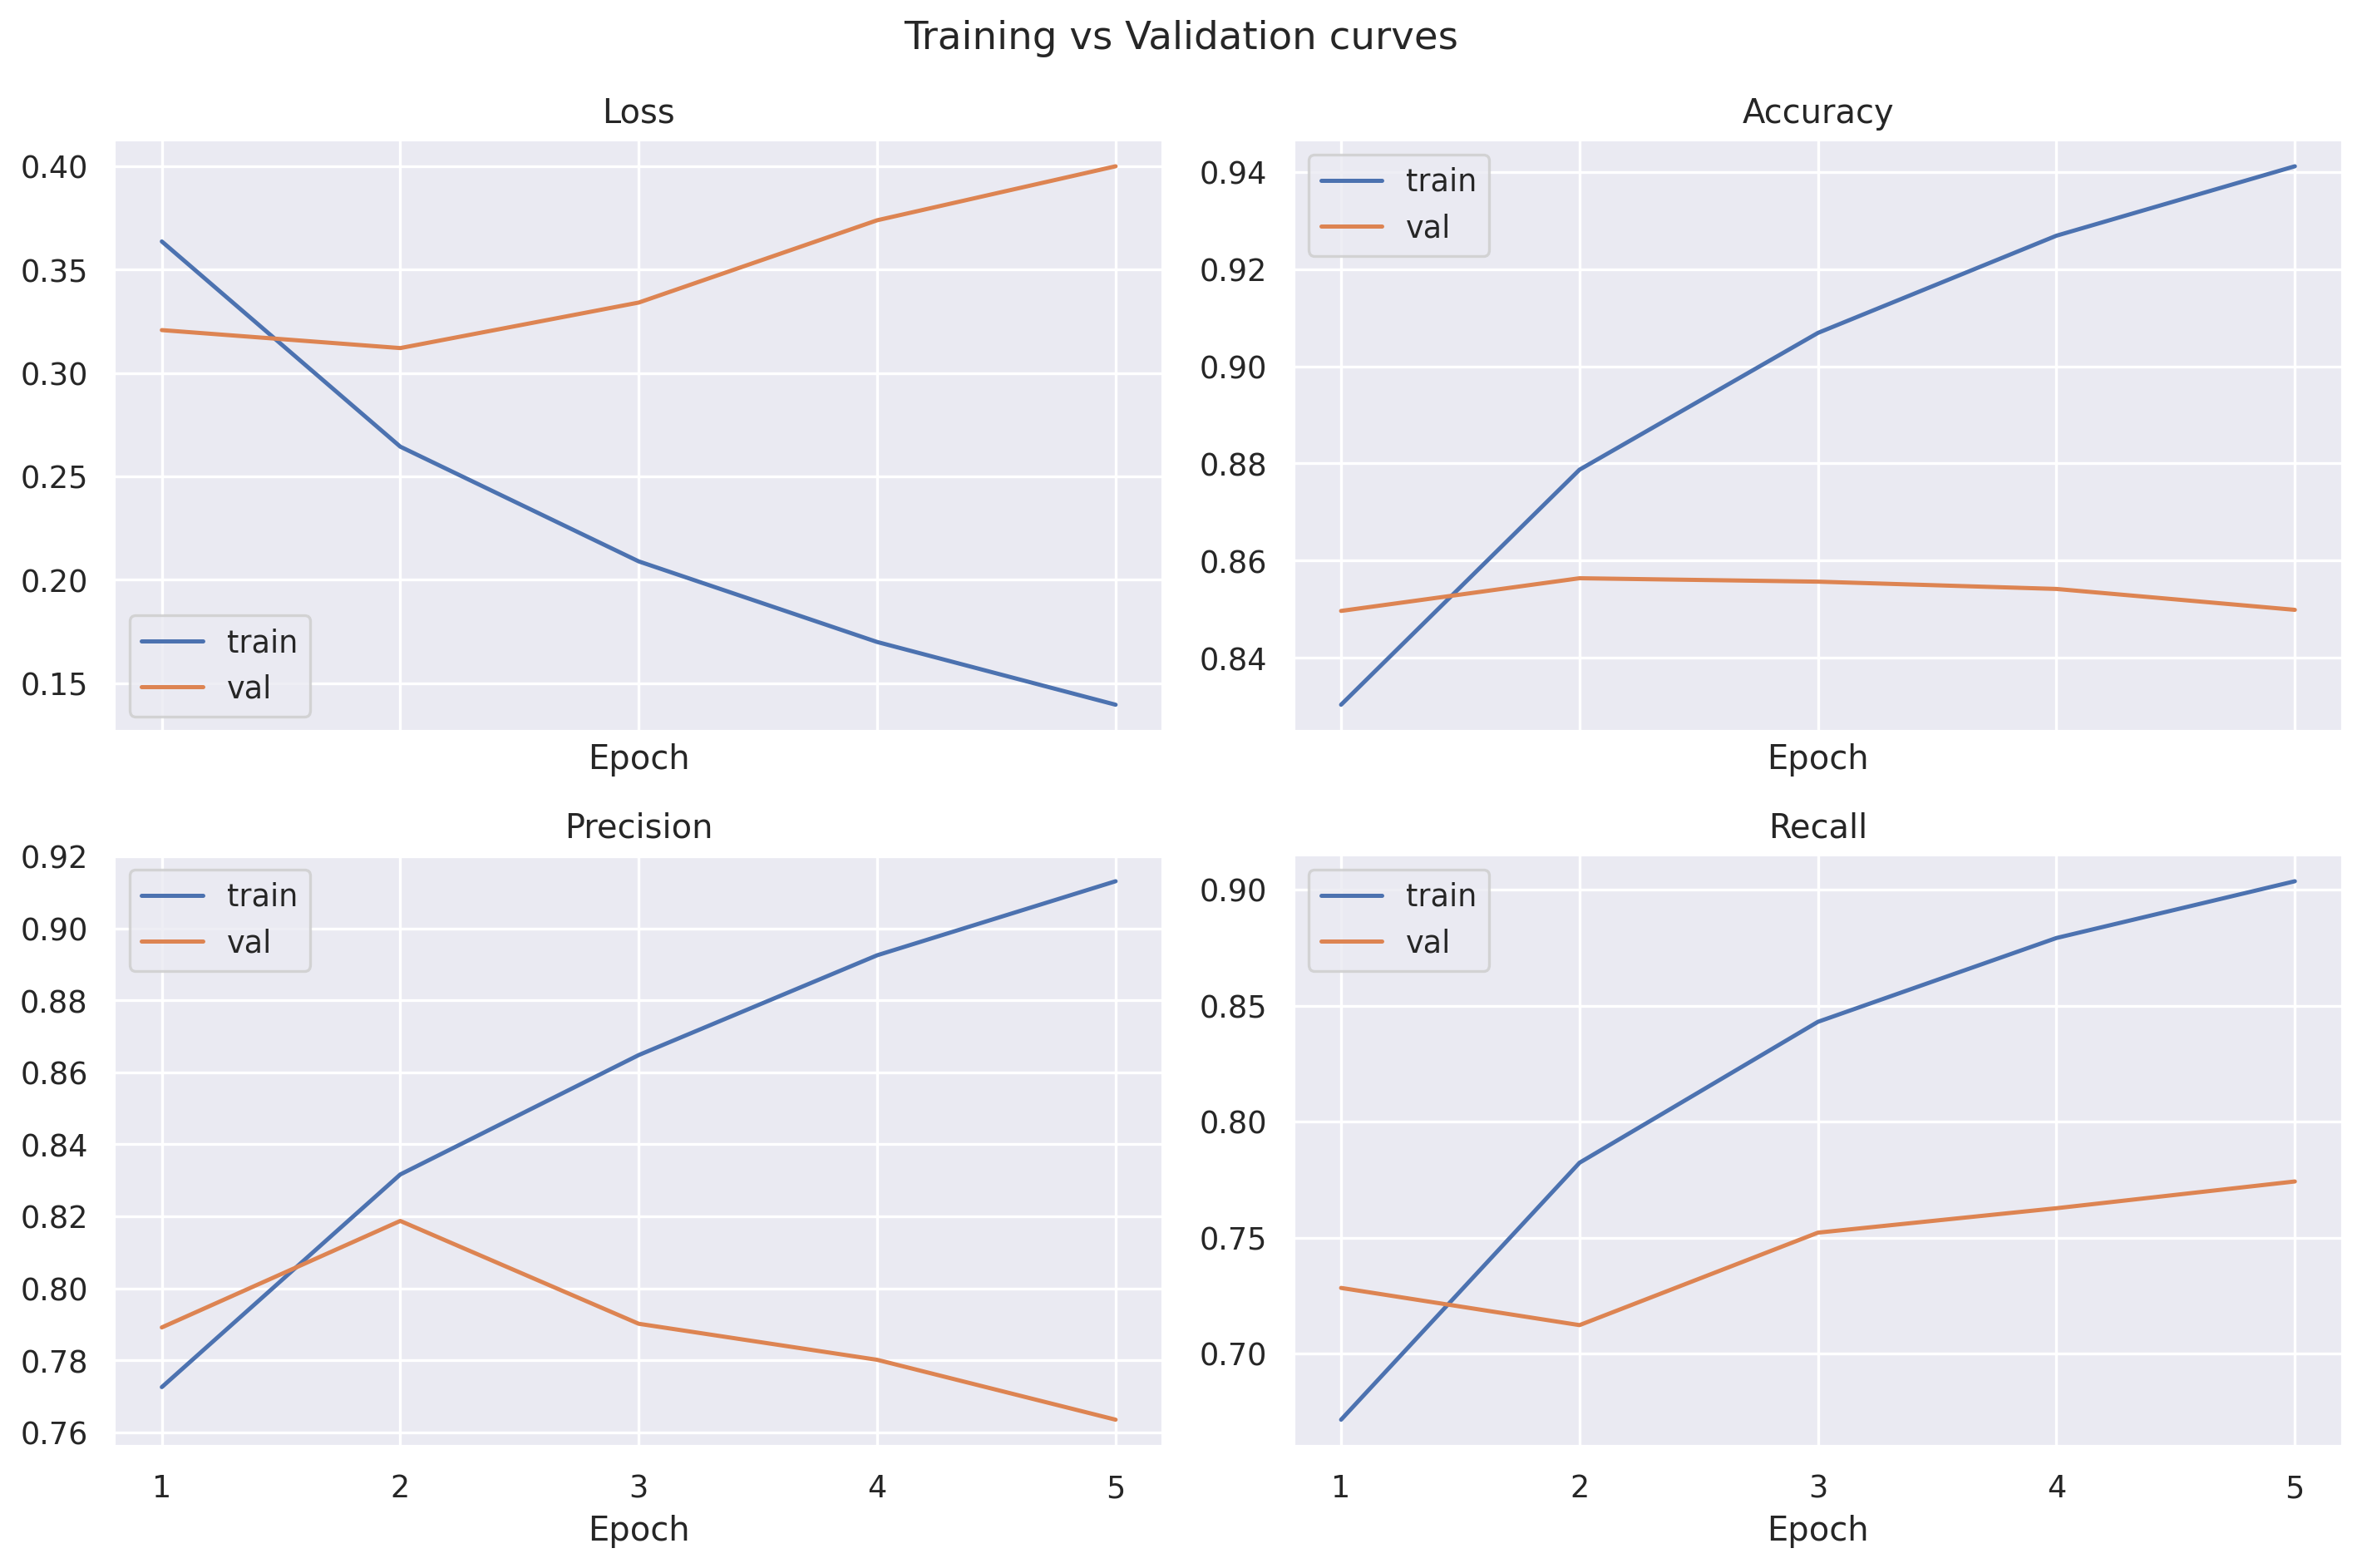

In [ ]:
# Visulization of learning curves for metrics calculated during training

metrics = ['loss', 'accuracy', 'precision', 'recall']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

for ax, m in zip(axes.flatten(), metrics):
    train_values = history.history.get(m)
    val_values = history.history.get('val_'+m)

    ax.plot(train_values, label='train')
    ax.plot(val_values, label='val')
    ax.set_title(m.capitalize())
    ax.set_xlabel('Epoch')
    ax.legend()

plt.xticks(np.arange(len(train_values)), np.arange(1, len(train_values)+1))
plt.suptitle("Training vs Validation curves", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('RRN_model.keras')

## 5) Model evaluation

In this phase, a complete evaluation of the trained Neural Network models is performed, by obtaining probability prdictions and corresponding binary predictions (with a classification threshold of 0.5) on the (unbalanced) test dataset. Then, a series of evaluation metrics, overall (considering the weighted average) and by label, is calculated.

In [ ]:
# Probability predictions
y_proba = model.predict(X_test_seq, batch_size=256, verbose=0)

# Binary predictions
threshold = 0.5
y_pred  = (y_proba >= threshold).astype(int)

In [ ]:
# Calculate metrics

metrics_dict = {'overall': {}, 'by_label': {}}

# Overall (weighted) metrics
metrics_dict['overall']['accuracy'] = accuracy_score(y_test, y_pred)
metrics_dict['overall']['precision'] = precision_score(y_test, y_pred, average='weighted')
metrics_dict['overall']['recall'] = recall_score(y_test, y_pred, average='weighted')
metrics_dict['overall']['f1'] = f1_score(y_test, y_pred, average='weighted')
metrics_dict['overall']['roc_auc'] = roc_auc_score(y_test, y_proba, average='weighted')
metrics_dict['overall']['pr_auc'] = average_precision_score(y_test, y_proba, average='weighted')

# By‑label metrics
for i, label in enumerate(label_cols):
    metrics_dict['by_label'][label] = {
        'accuracy': accuracy_score(y_test[:, i], y_pred[:, i]),
        'precision': precision_score(y_test[:, i], y_pred[:, i]),
        'recall': recall_score(y_test[:, i], y_pred[:, i]),
        'f1': f1_score(y_test[:, i], y_pred[:, i]),
        'roc_auc': roc_auc_score(y_test[:, i], y_proba[:, i]),
        'pr_auc': average_precision_score(y_test[:, i], y_proba[:, i])
    }

In [ ]:
print(f"Overall metrics (weighted average) - threshold: {threshold}")
for k, v in metrics_dict['overall'].items():
    print(f" {k:10s}: {v:.3f}")

Overall metrics (weighted average) - threshold: 0.5
 accuracy  : 0.720
 precision : 0.213
 recall    : 0.752
 f1        : 0.326
 roc_auc   : 0.863
 pr_auc    : 0.339


By observing overall metrics, the model achieved a moderately high recall value (about 0.75) but a low precision value (about 0.2). This means that, on average, the model is able to classify most of toxic comments but the majority of comments predicted as toxic are actually "clean".

In [ ]:
per_label_df = pd.DataFrame(metrics_dict['by_label']).T
print(f"By‑label metrics - threshold: {threshold}")
display(per_label_df.style.format("{:.4f}"))

By‑label metrics - threshold: 0.5


,accuracy,precision,recall,f1,roc_auc,pr_auc
toxic,0.7806,0.2687,0.7486,0.3955,0.8349,0.4211
severe_toxic,0.8913,0.0561,0.6238,0.1029,0.9032,0.0987
obscene,0.8112,0.1981,0.8414,0.3207,0.8961,0.3781
threat,0.9964,0.2222,0.0833,0.1212,0.8870,0.0754
insult,0.8069,0.1775,0.8019,0.2907,0.8709,0.2532
identity_hate,0.9556,0.0710,0.3345,0.1171,0.8789,0.0593


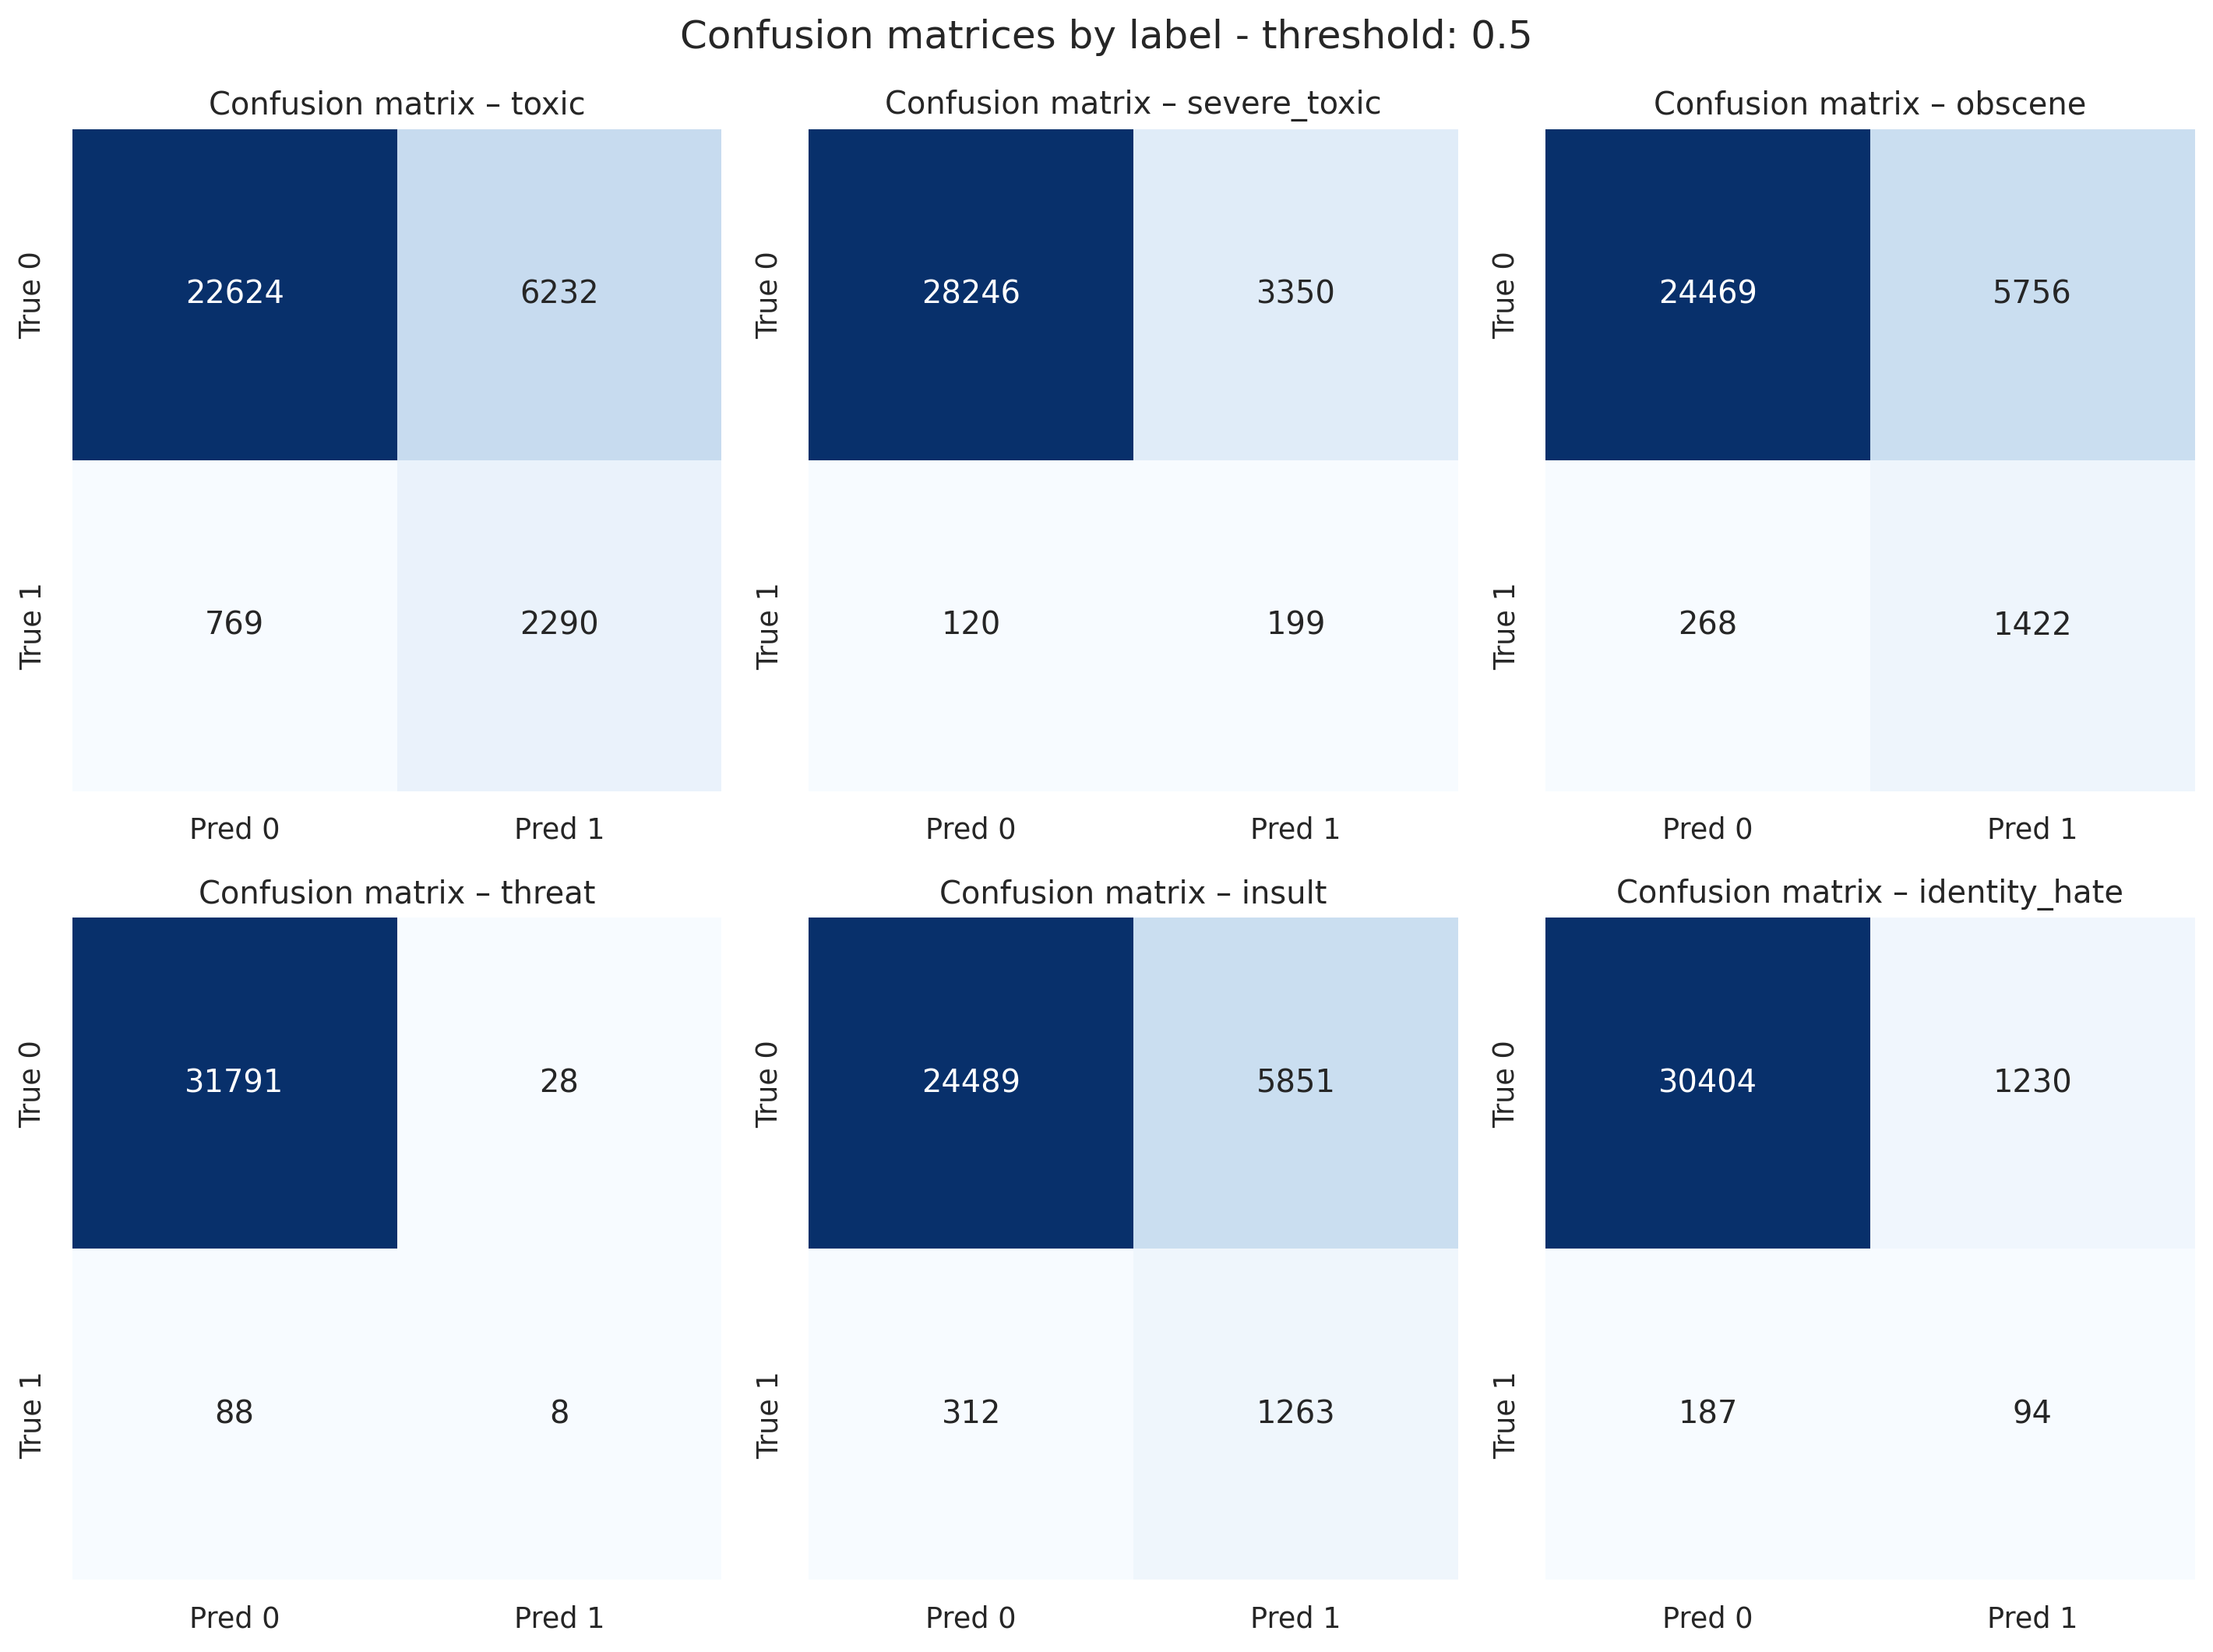

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 9))
axes = axes.flatten()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    axes[i].set_title(f"Confusion matrix – {label}")

plt.suptitle(f"Confusion matrices by label - threshold: {threshold}", fontsize=15)
plt.tight_layout()
plt.show()

The results of metrics and confusion matrices by labels show that the model achieved the worst performances with the toxic categories with a lower number of samples in the test dataset, namely "severe toxic", "threat" and "identity hate". It must be noted that these three categories were still underrepresented also in the training dataset after the balancing procesure.

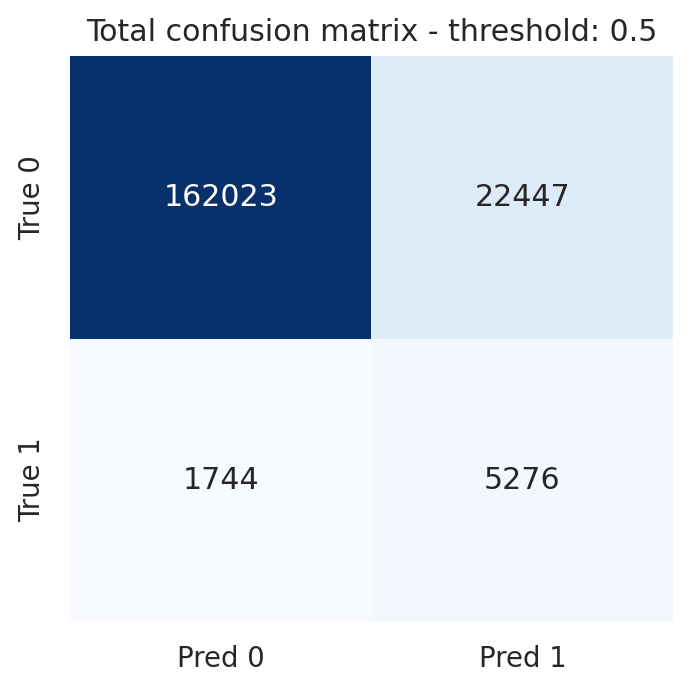

In [ ]:
# Calculate total confusion matrix (sum of by‑label matrices)
cm_total = np.zeros((2, 2), dtype=int)
for i in range(len(label_cols)):
    cm_total += confusion_matrix(y_test[:, i], y_pred[:, i])


# Plot total confusion matrix
plt.figure(figsize=(4, 4), dpi=180)
sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.title(f"Total confusion matrix - threshold: {threshold}")
plt.tight_layout()

Here, the Receiver Operating Characteristic (ROC) curves for each label are calculated from the probability predictions and visulized to show the false positive rate versus the true positive rate for different classification thresholds values between 0.0 and 1.0.

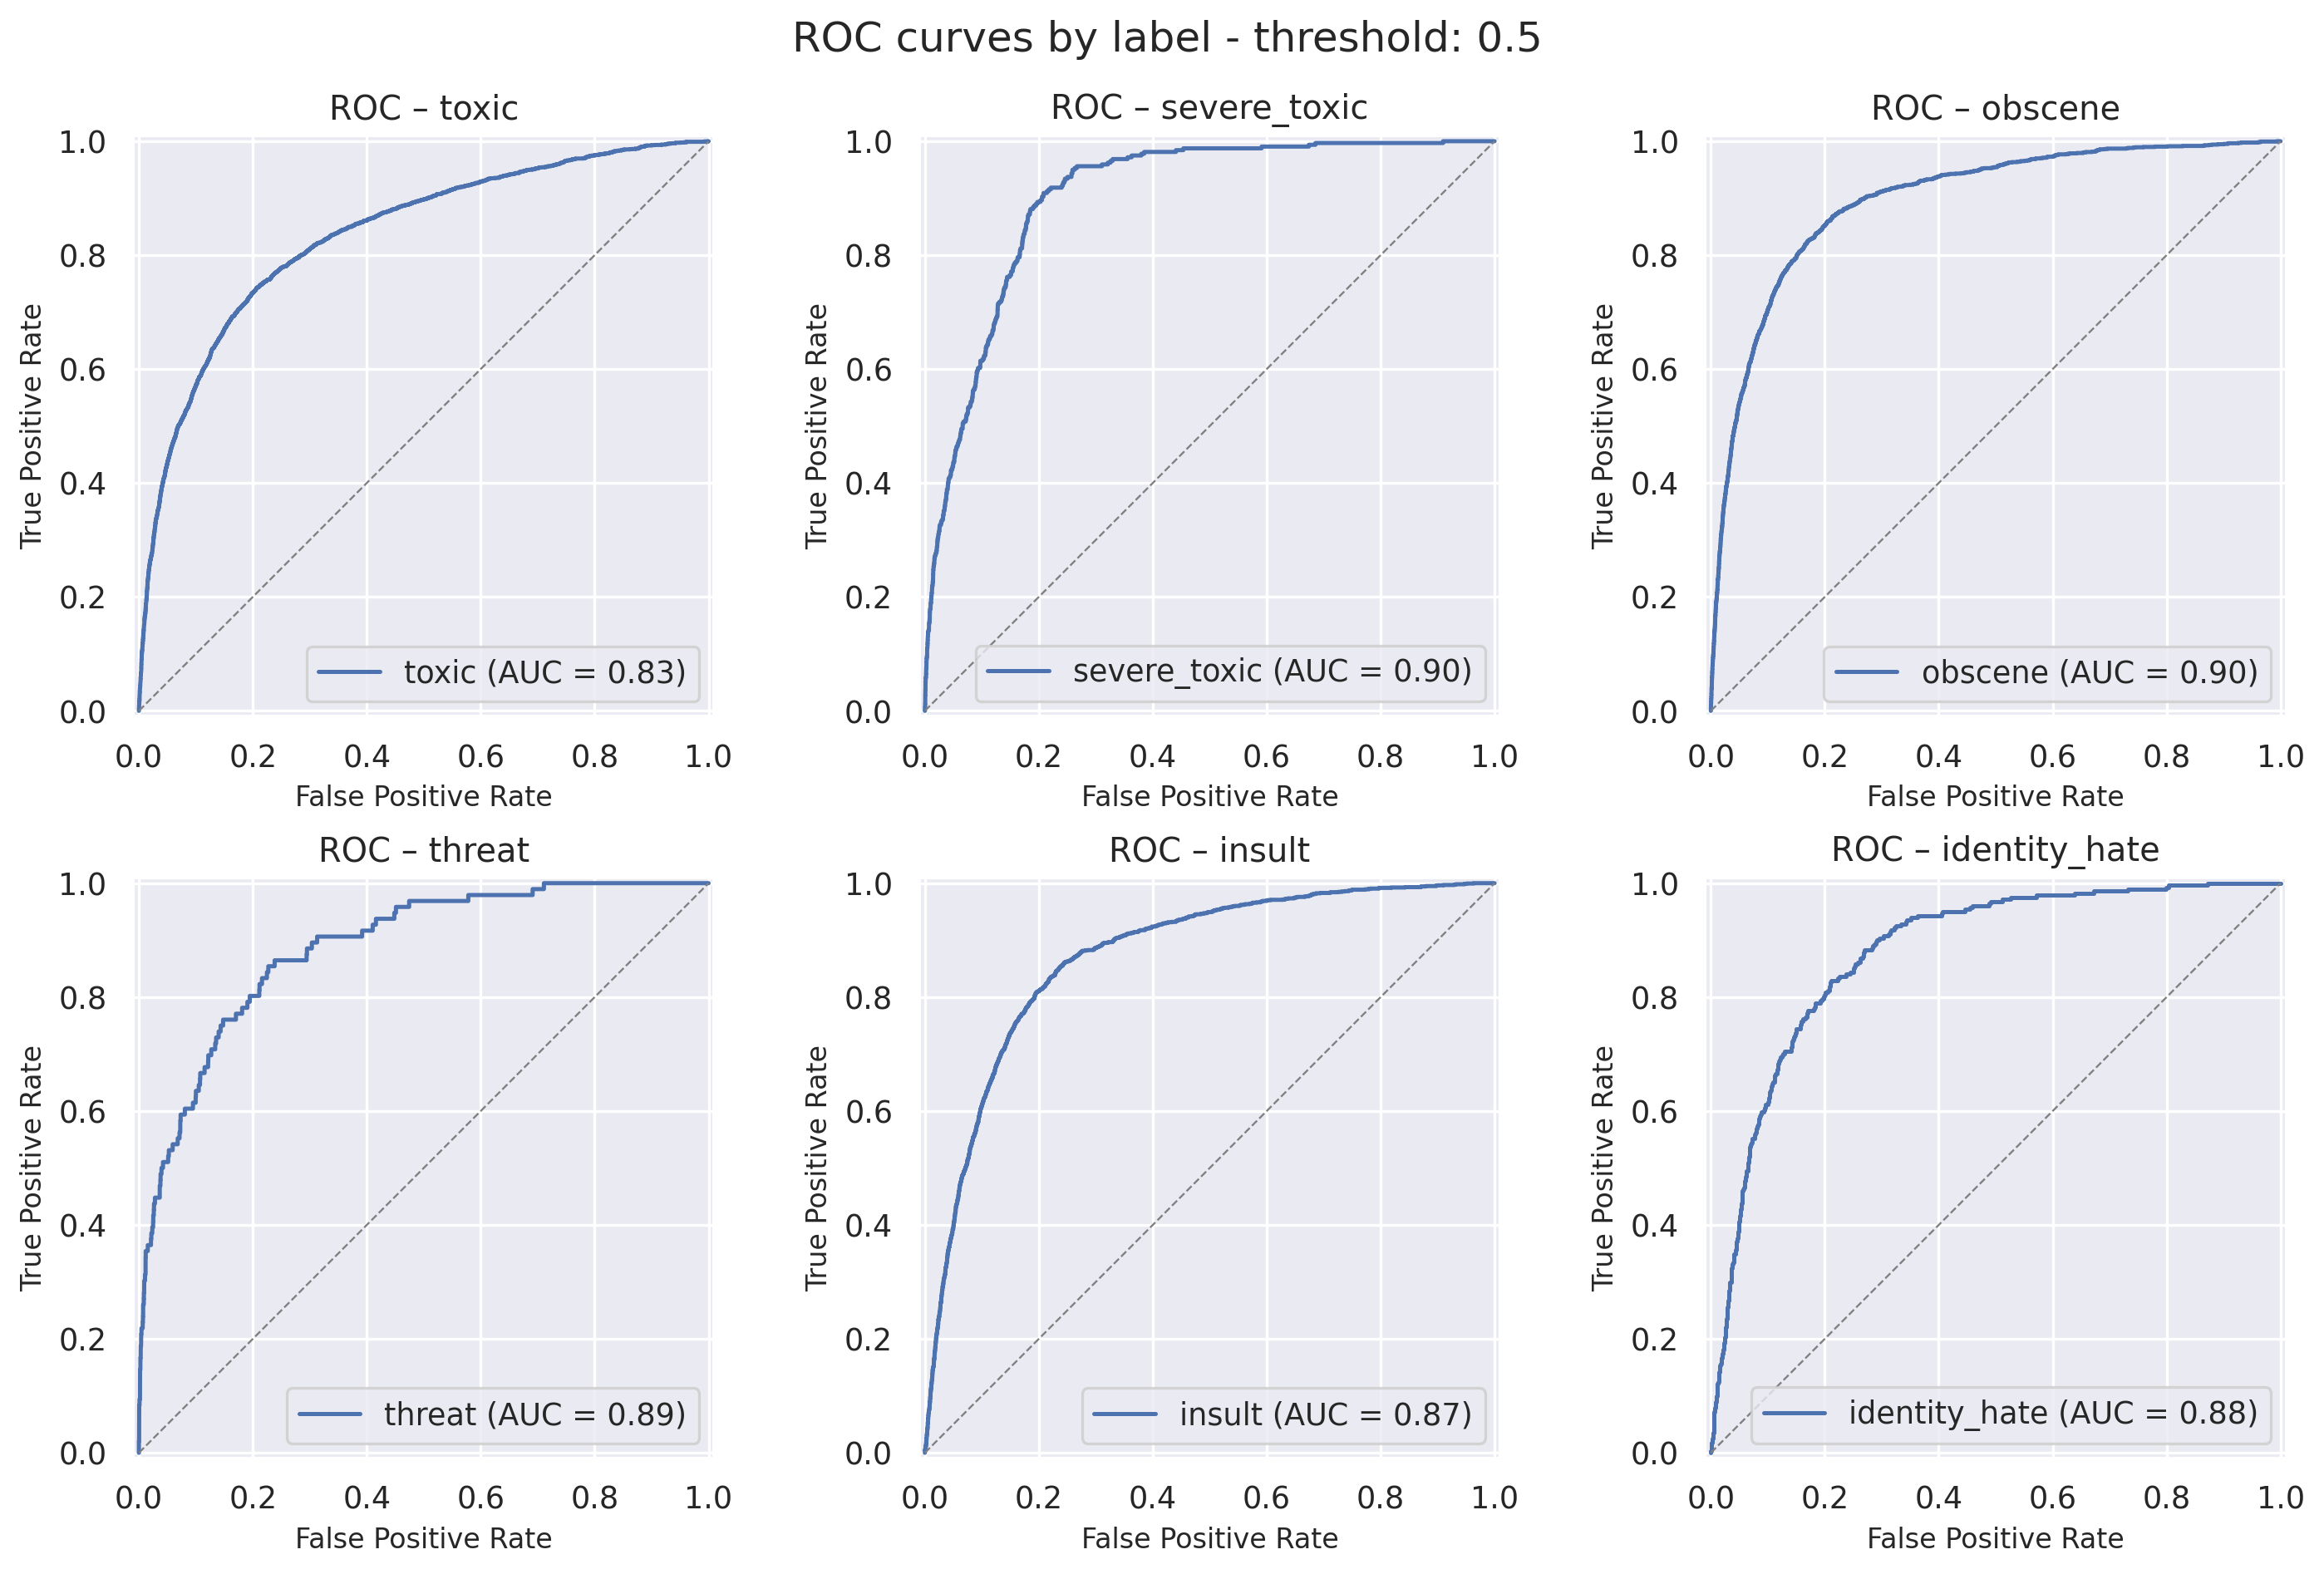

In [ ]:
# Plot ROC curves
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, label in enumerate(label_cols):
    RocCurveDisplay.from_predictions(
        y_test[:, i], y_proba[:, i],
        ax=axes[i],
        name=f"{label}"
    )
    axes[i].plot([0,1],[0,1],'--', lw=0.7, color='gray')
    axes[i].set_title(f"ROC – {label}")
    axes[i].set_xlabel('False Positive Rate', fontsize=10)
    axes[i].set_ylabel('True Positive Rate', fontsize=10)

plt.suptitle(f"ROC curves by label - threshold: {threshold}", fontsize=15)
plt.tight_layout()
plt.show()

However, for strongly imbalanced dataset (with a significantly higher number of samples in the negative class respect to the positive class), the precision-recall curve represents a more useful visualization of the model classification performance, as it evaluates the fraction of true positives among positive predictions.

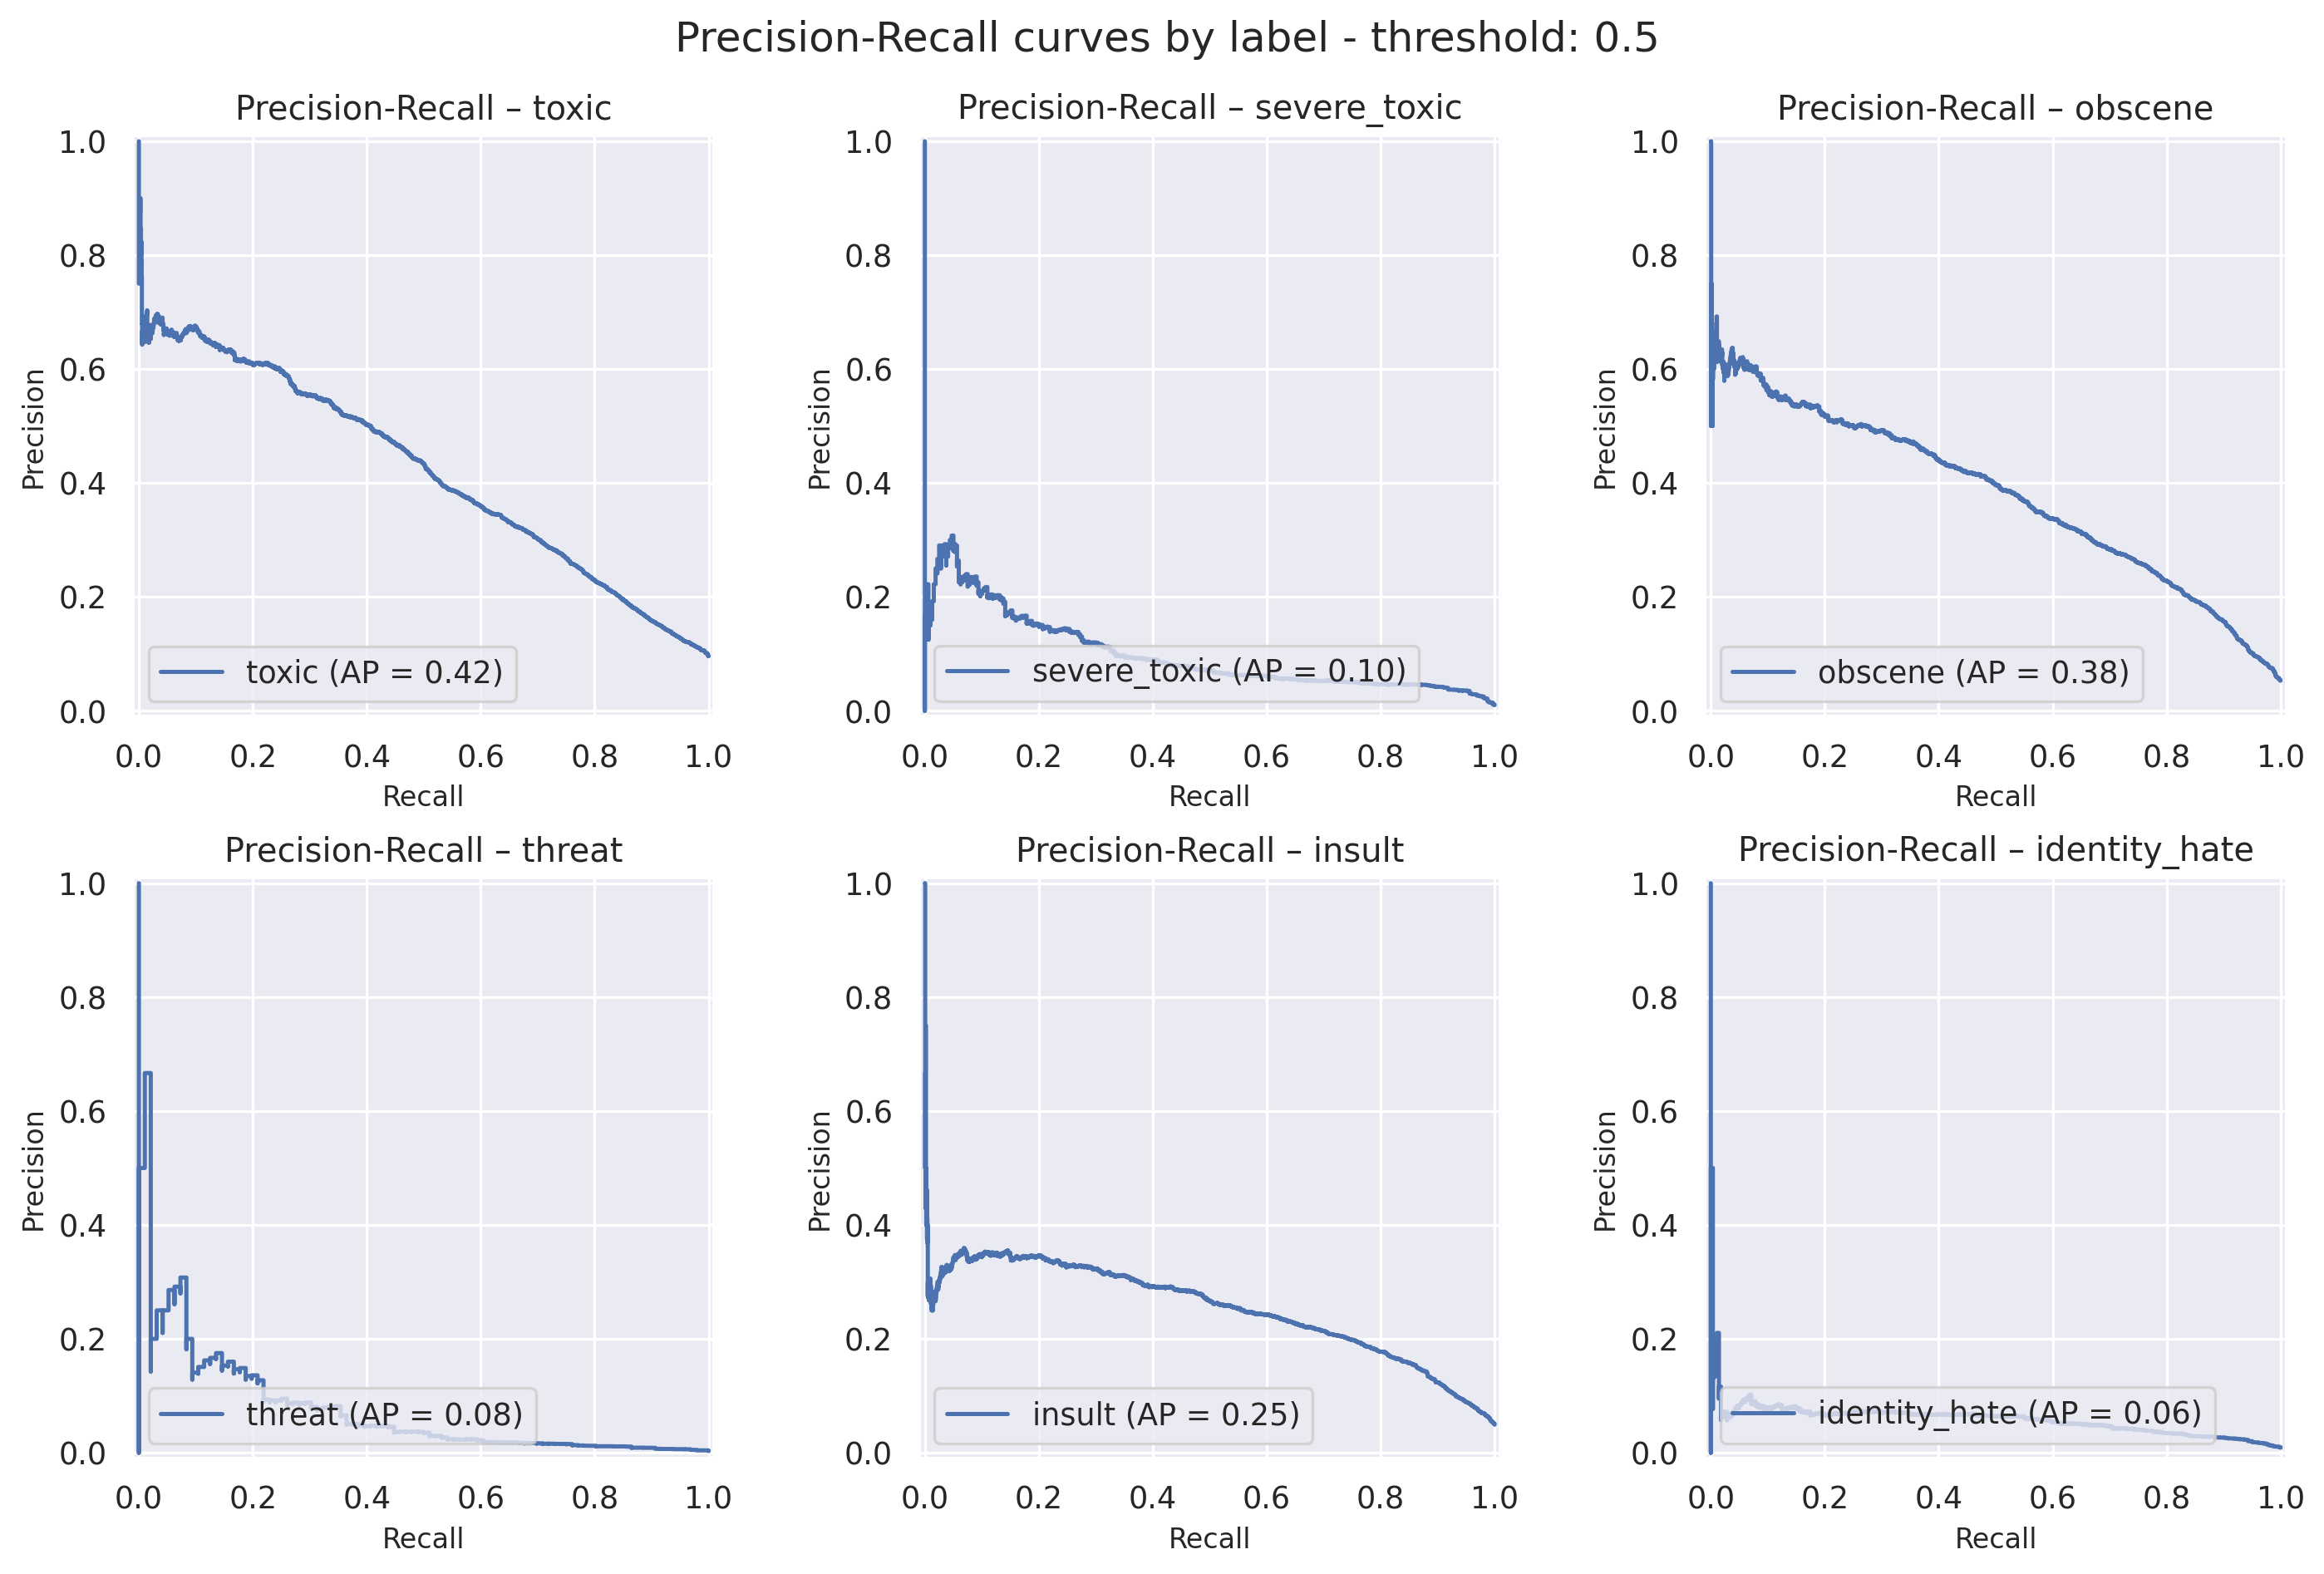

In [ ]:
# Plot Precision-Recall curves
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, label in enumerate(label_cols):
    PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_proba[:, i],
        ax=axes[i],
        name=f"{label}"
    )
    axes[i].set_title(f"Precision‑Recall – {label}")
    axes[i].set_xlabel('Recall', fontsize=10)
    axes[i].set_ylabel('Precision', fontsize=10)

plt.suptitle(f"Precision‑Recall curves by label - threshold: {threshold}", fontsize=15)
plt.tight_layout()
plt.show()

As can be observed from the areas under the curve (AUC), the model particularly struggled to classify the three underrepresented categories ("severe toxic", "threat" and "identity hate").

## 6) Predictions on text examples

In this section, a method is implemented to test the trained Deep Learning model on generic examples of potentially toxic comments and visualize the corresponding model predictions. Specifically, this method has the following functionalities:
- take the text of a comment as input
- apply the cleaning and vectorization processes used for the train and test datasets
- calculate the probability and binary predictions (based on a defined threshold) for the input text using the trained model
- visualize the probabilities of each toxicty label with a bar plot, where bars below the threshold (clean) are colored in green and bars above (toxic) in red

In [ ]:
# Load model
model = models.load_model('RRN_model.keras')

In [ ]:
# Define a function to preprocess text, run the model and plot predictions

def predict_and_plot(text, vectorizer, model, threshold, label_names, ax):

    # Apply the same preprocessing used for training
    processed = clean_text(text)
    seq = vectorizer([processed])

    # Predict toxicity (probability and binary)
    probs = model.predict(seq, verbose=0)[0]
    preds = (probs >= threshold)

    colors = ['red' if p else 'limegreen' for p in preds]

    ax.bar(label_names, probs, color=colors)
    ax.axhline(threshold, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.tick_params("x", rotation=35, labelsize=8)

    # Shorten long comment texts in the titles
    snippet = text if len(text) < 120 else text[:117] + "..."
    ax.set_title(f'"{snippet}"', fontsize=10)

    # Annotate each plot with toxicity labels
    toxic_labels = [lbl for lbl, flag in zip(label_names, preds) if flag]
    if toxic_labels:
        detected_labels = "Toxic labels: " + ", ".join(toxic_labels)
    else:
        detected_labels = "No toxic labels"

    ax.text(0.5, -0.35, detected_labels,
            transform=ax.transAxes,
            ha='center', va='top', fontsize=9, wrap=True)

    # Annotate each bar with probability
    for i, p in enumerate(probs):
        ax.text(i, 
                p/2 if p/2 > .1 else p + .03,
                f"{p:.2f}", ha='center', va='bottom', fontsize=8,
                bbox = dict(boxstyle="round", ec='black', fc="#ffffff75", lw=0.7))

In [164]:
example_comments = [
    "Shut up, nobody cares about your opinion.",
    "Go back to your own country, you don't belong here!",
    "I hope something terrible happens to you.",
    "Your existence is worthless and pathetic.",
    "You are an embarrassment to humanity.",
    "I'll find you and make you regret it!",
    "I completely agree with your point!",
    "Thank you for sharing this valuable information.",
    "Interesting perspective, I hadn't considered this before.",
    "Can you please explain this further?",
    "I learned something new today, thanks to you.",
    "Thanks for bringing attention to this important issue!",
]

Considering that, using a probability threshold of 0.5, the model results in a high number of false positives, the binary predictions are calculated with a threshold of 0.8.

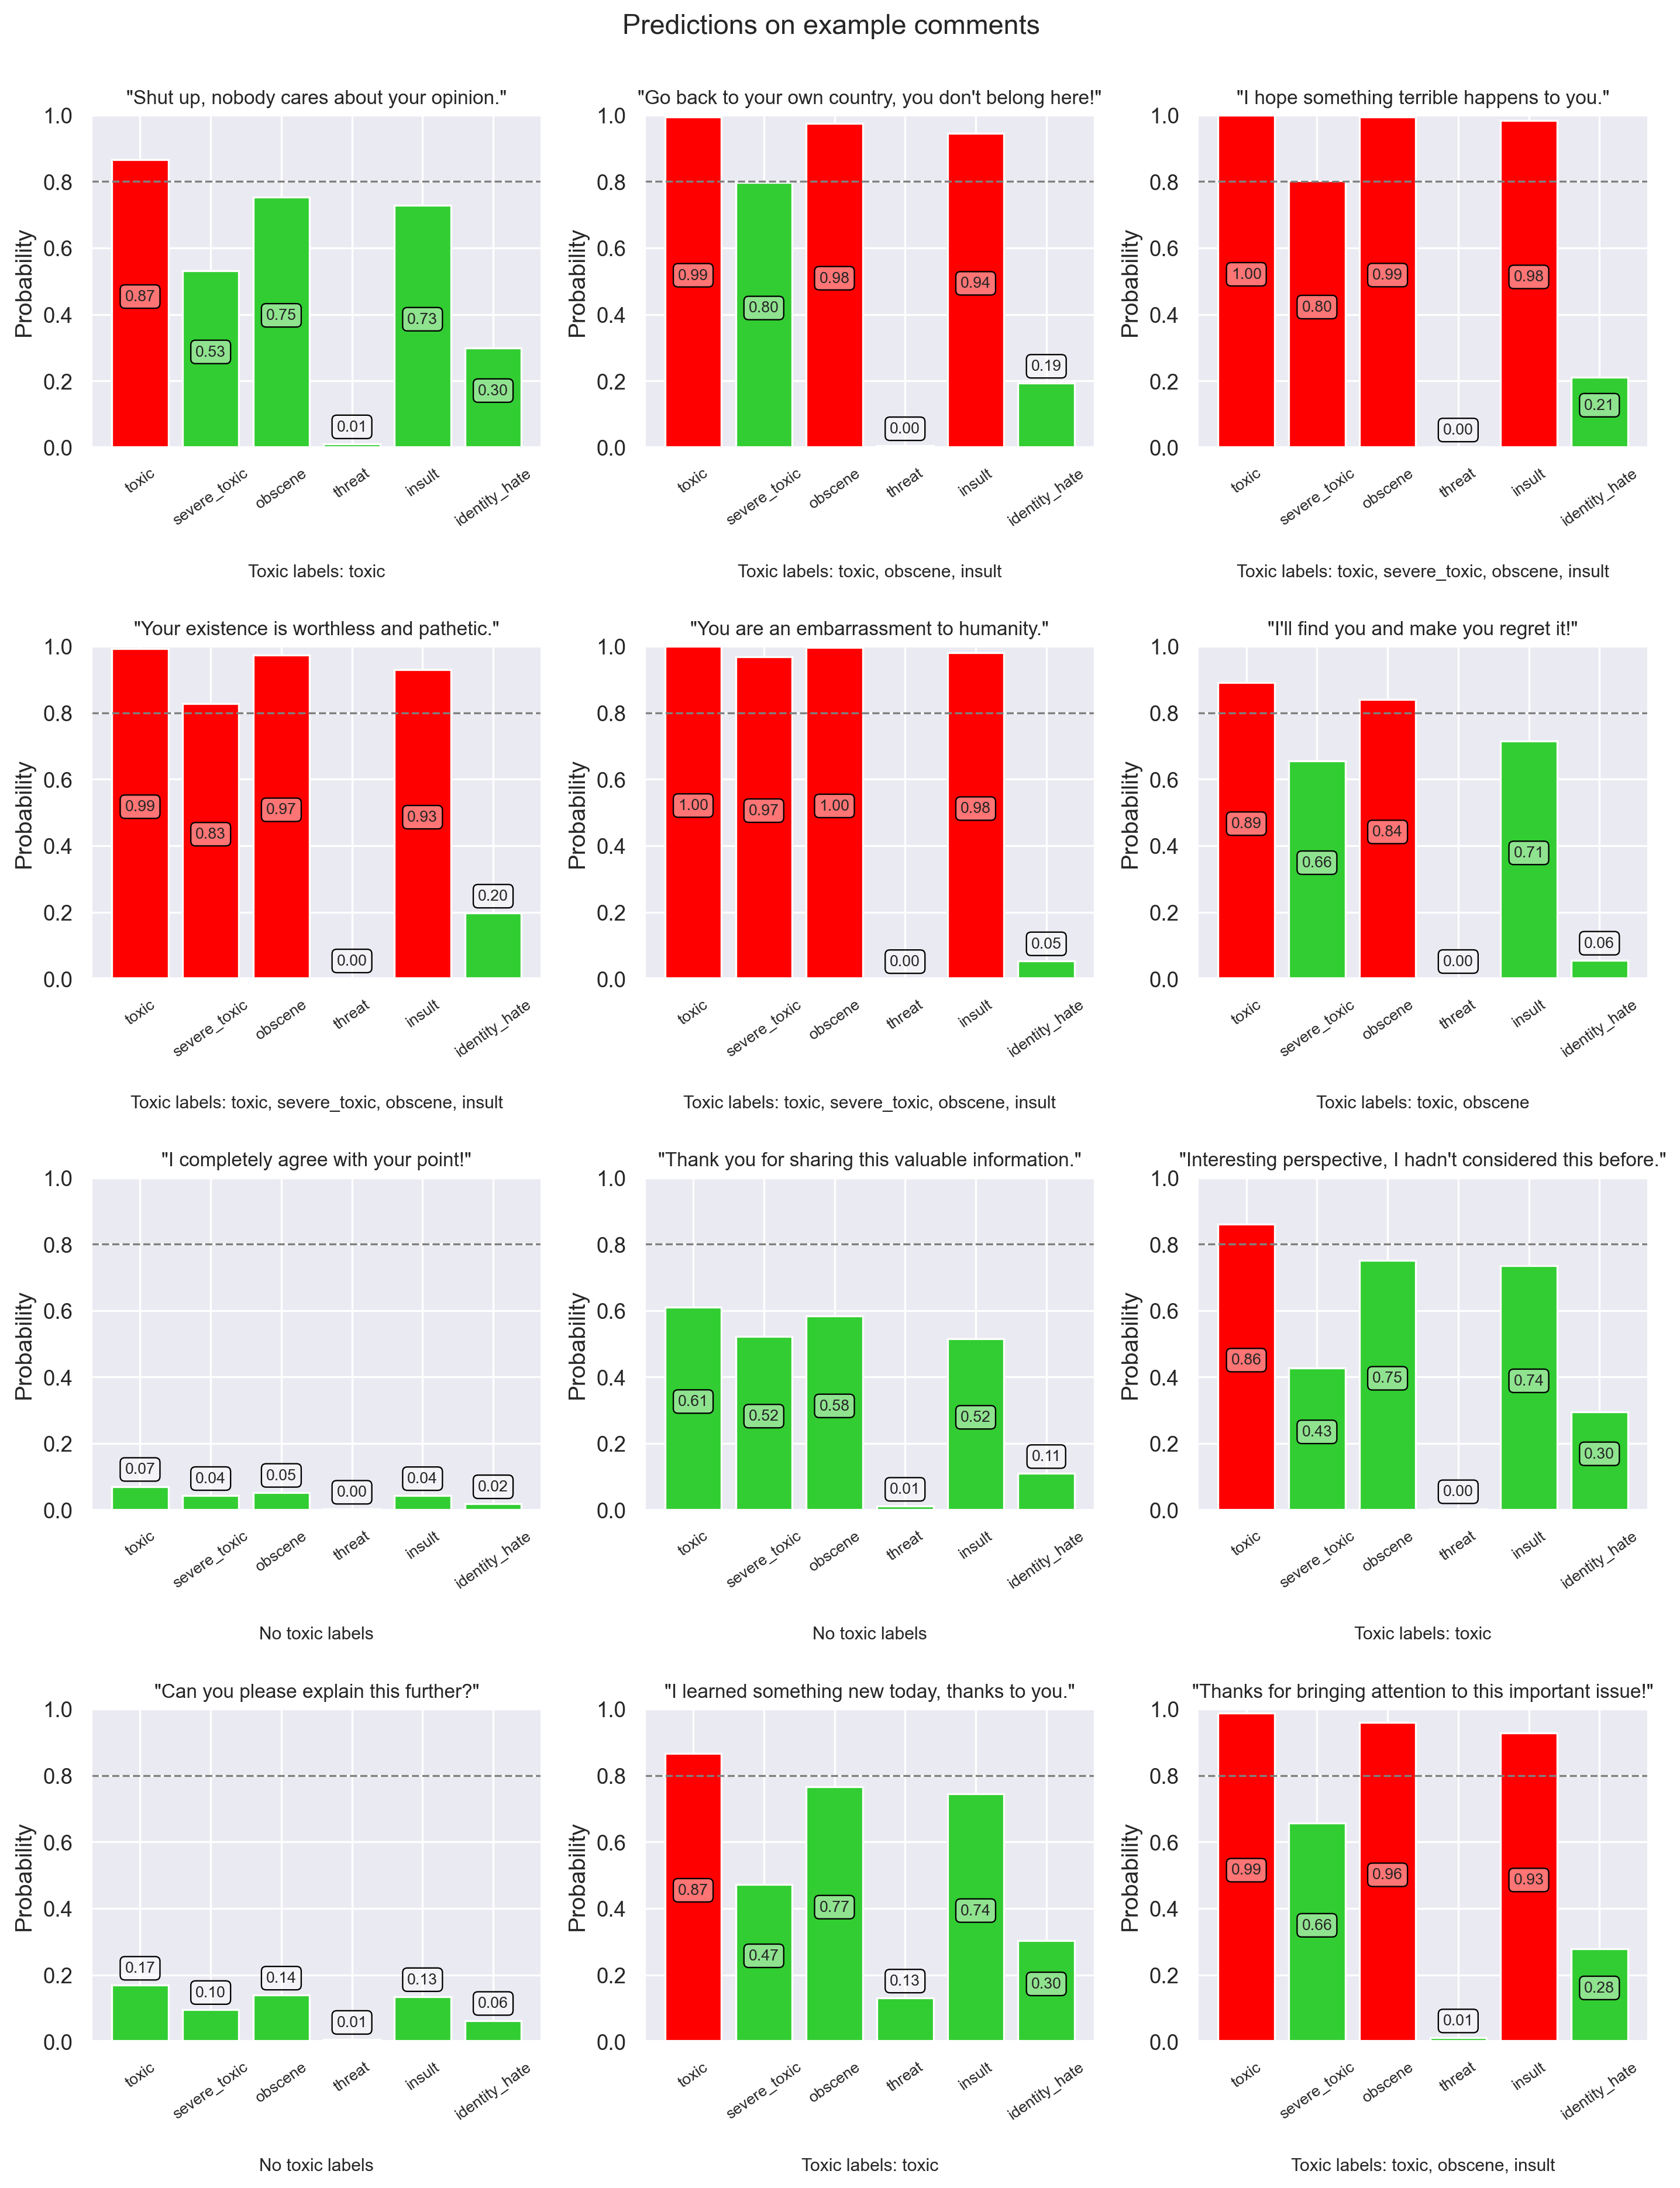

In [178]:
THRESHOLD = 0.8
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

n_examples = len(example_comments)
n_cols = 3
n_rows = math.ceil(n_examples / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for i, text in enumerate(example_comments):
    row, col = divmod(i, n_cols)
    predict_and_plot(text, vectorizer, model, THRESHOLD, label_names, axes[row][col])

plt.suptitle("Predictions on example comments", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In the examples considered, the model generally predicted higher probabilities of toxicity labels in comments with harsh and offensive tones respect to comments with neutral or pleasant tones, which are mostly below the threshold. However, some clear false positives are present.

## 7) Conclusions

The Neural Network model built in this project, while fully implementing the task of multilabel text classification, obtained basic performances considering evaluation metrics not sensitive to data imbalance, such as precision and recall. However, when tested on generic comment texts, the model demostrated a certain ability to generalize, suggesting that it represents a promising approach if implemented with higher quality data. In fact, the dataset used for the classification task, despite a good overall size, includes a relatively low number of positive samples, espacially for some classes, probably not ideal for achieving high classification perfomances. The data augmentation methods used in this project reduced the data imbalance but likely did not allow the model to fully learn the general features of the different toxicity categories.

The lower precision values respect to recall is a common result with imbalanced data where the negative class is predominant. However, the general worst performances of the model with the classes represented by a very low number of samples indicate that the model was not able to achieve good classification and generalization capabilities for those classes, despite the augmentation process applied. This suggests the need for more advanced augmentation methods or, ideally, obtaining a training dataset with a larger number of samples of toxic comments, especially for the minority classes such as "severe toxic", "threat" and "identity hate".